# Coding project - classification of medical images

The goal of this project is to evaluate your capacity to design a deep learning pipeline for **image** analysis on a real case study, from data processing to interpretation of the model's result. The project accounts for 60% of the course's grade, and will be evaluated as follows:

Criterion | Weight |Details
-------------------|------------------|----------
Quality of the oral  | 30% | Clarity, discussion, ideas for improvement
Coding quality | 30% | Relevant methods, advanced techniques, quality of implementation, reproducibility
Interpretation | 30% | Relevance and quality of interpretation, quality of visual representations
Performance | 10% | Final performance on the classification task of interest

**Auteurs : Daniel ASHRAFUL, Noaga Ferdinand Arthur DAHANI, Ahmed Salem HABIBI**

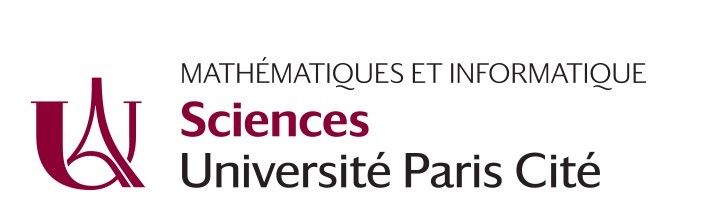

## Resumé
<font color="purple">Pour resumer le travail fait dans ce projet, on dira qu'on a dans un premier lieu explorer les images importées aléatoirement, representer la distribution des classes, c'est là que nous avons remarqué le déséquilibre des classes, alors nous avons formulé l'hypothèse que nos modèles auront tendance à moieux classer les images de la classe majoritaire(IDC-neg).De ce fait nous avons explorer des alternatives afin de mieux prédire la classe minoritaire(IDC-pos). Ensuite nous avons utilisés des modèles pré entrainés comme ResNet et Efficient. Dans le but toujours d'optimiser la performance de nos modèles nous avons fait de la data augmentation et la sélection des hyperparamètres. Enfin afin de savoir sur quelles zones des images nos modèles se concentrent pour la déscision nous avons fait les cartes de Chaleur.</font>

# Predicting invasive ductal carcinoma in tissue slices

## Motivations

Breast cancer is the most common form of cancer in women, and Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. Accurately identifying IDC is an important clinical task, to assign an aggressiveness rate to a sample. To identify IDC, a biopsy is often done to remove small tissue samples. Then, the tissue sample is visualized by a pathologist, who makes the diagnosis. In the past 10 years, Deep learning tools have been developed to accelerate the time to diagnosis, with automated models which analyze digital images of tissue samples in order to propose a diagnosis. However, several technical challenges remain, in particular to obtain more robust deep learning tools.

## Data set

The original dataset consisted of 162 scanned images of Breast Cancer (BCa) samples. These images are of very high resolution, and thus extremely heavy. Thus, 277,524 patches of size 50 x 50 were extracted, resulting in 198,738 IDC negative and 78,786 IDC positive samples. The original study can be found [here](https://pubmed.ncbi.nlm.nih.gov/27563488/), and examples of resulting image patches are shown below.

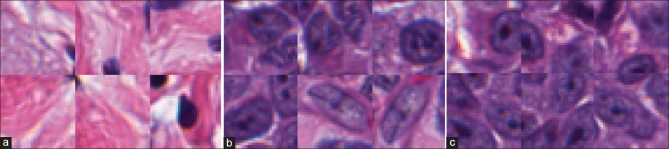




## Set up



Don't forget to change the device to GPU T4

In [1]:
import torch
#Reproductiblité
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### TODO: set the device to "cuda" if a GPU is available, "CPU" otherwise

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Download the data set using the following code, and check the variable `path` to see where the downloaded folder is located.

In [2]:
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import os
import numpy as np
import pandas as pd
import kagglehub
from glob import glob
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,auc
import seaborn as sns


In [3]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-histopathology-images' dataset.
Path to dataset files: /kaggle/input/breast-histopathology-images


Load the data set, visualize a few samples, store the images and labels in python obkects.

In [4]:
# Data download should take ~6min
data = glob('/kaggle/input/breast-histopathology-images/**/*.png', recursive=True)

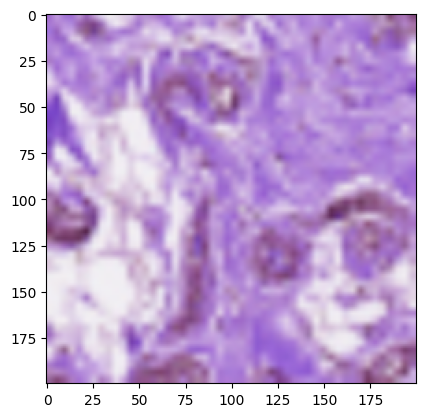

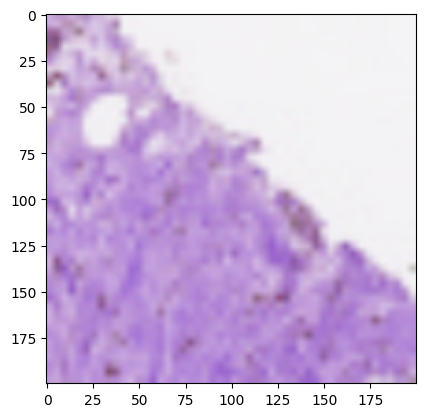

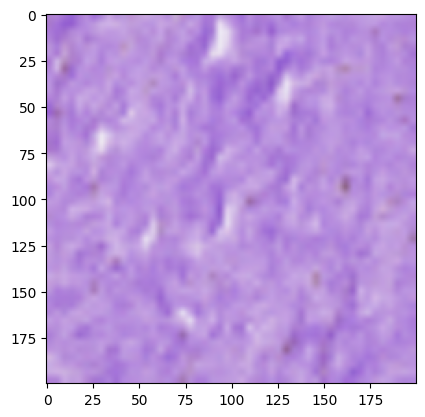

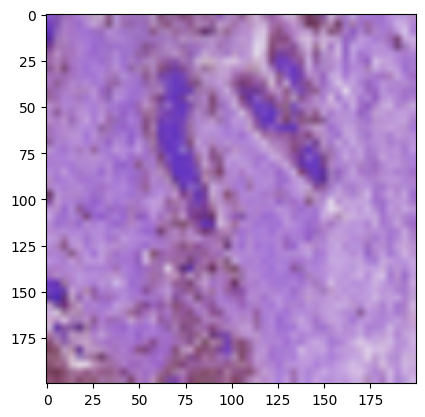

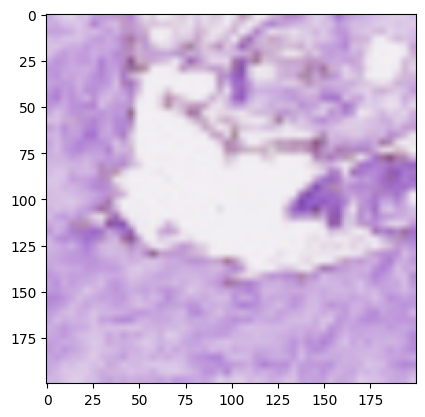

In [5]:
for i in data[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(200,200))
    plt.imshow(img_1,cmap='binary')
    plt.show()

## Chargement aléatoire des images

In [6]:
images=[]
labels=[]
# We only consider the 4,000 first images for the sake of computational time
# Feel free to reduce or increase the number of images depending on your resources
idx_choose = np.random.choice(np.arange(len(data)), 4000, replace=False).tolist()

for idx in idx_choose:
    i = data[idx]
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(100,100))
        images.append(img_1)
        labels.append(label)

## Statistiques Descriptive des images

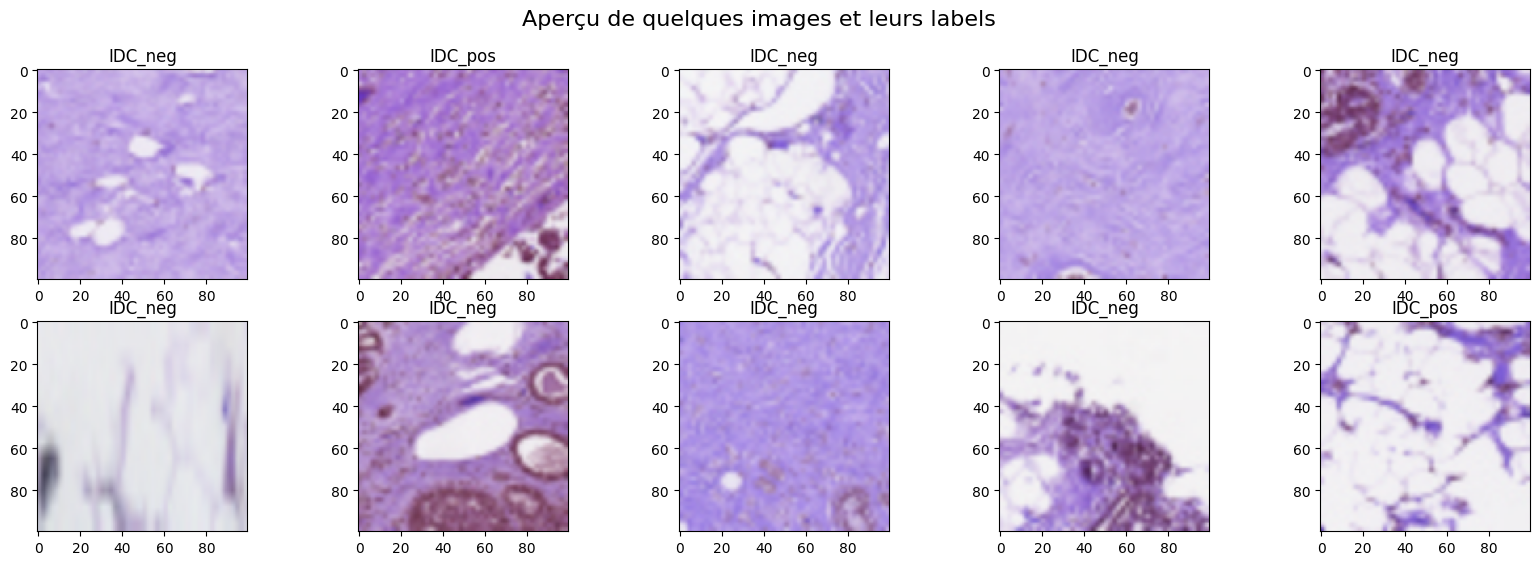

In [7]:
#representation aléatoire des images
indices=np.random.choice(len(images),10,replace=False)
plt.figure(figsize=(20, 6))
for i, idx in enumerate(indices):
    plt.subplot(2,5, i + 1)
    img = images[idx]
    label = labels[idx]
    plt.imshow(img)
    plt.title("IDC_pos" if label == '1' else "IDC_neg")

plt.suptitle("Aperçu de quelques images et leurs labels", fontsize=16)
plt.show()

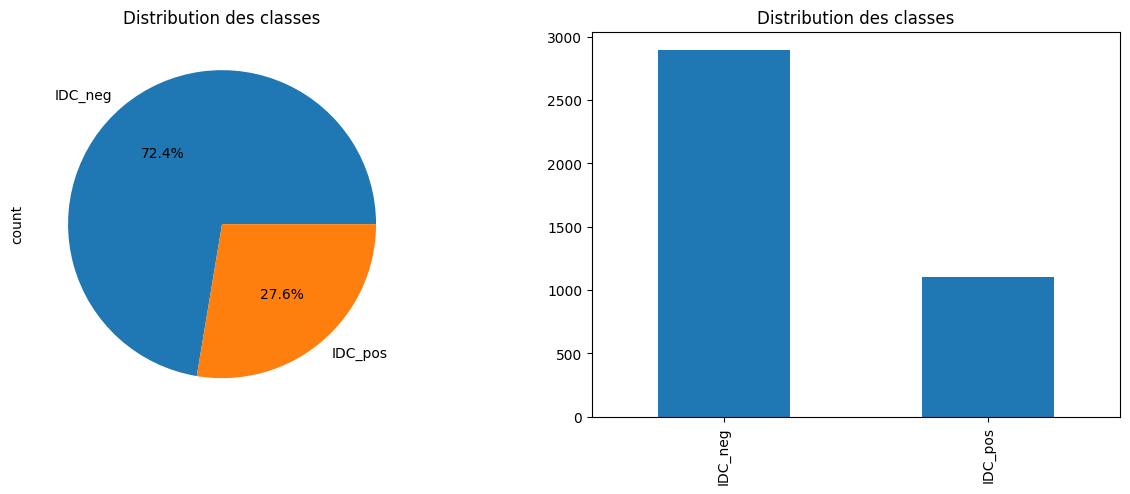

In [8]:
#distribution des classes
mapping={'0':"IDC_neg",'1':"IDC_pos"}
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
df = pd.Series(labels).map(mapping).value_counts()
df.plot(kind="pie", title="Distribution des classes",autopct='%1.1f%%')
plt.subplot(1,2,2)
df.plot(kind="bar", title="Distribution des classes")
plt.show()

In [9]:
#détection d'équilibre
ratio=df.max()/df.min()
print("le ratio est:",ratio)

le ratio est: 2.6199095022624435


Vu le ratio l'accuracy seule sera une métrique trompeuse.

# **Préparation des données**

<font color="blue">Division du jeu de données en entrainement,test,validation</font>.

In [10]:
#division du dataset en train,test, val
from sklearn.model_selection import train_test_split
X_train,X_temp,y_train,y_temp=train_test_split(images,labels,test_size=0.3,stratify=labels)
X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,test_size=0.2,stratify=y_temp)

In [11]:
print(f"\nTrain : {len(X_train)} échantillons ({100*len(X_train)/len(images):.1f}%)")
print(f"Val   : {len(X_val)} échantillons ({100*len(X_val)/len(images):.1f}%)")
print(f"Test  : {len(X_test)} échantillons ({100*len(X_test)/len(images):.1f}%)")


Train : 2800 échantillons (70.0%)
Val   : 240 échantillons (6.0%)
Test  : 960 échantillons (24.0%)


## Création d'un ensemble de données Pytorch

In [12]:
#création d'un enbsemble de données Pytorch
class CustumDataset(Dataset):
  def __init__(self,images,labels,transform=None):
    self.images=images
    self.labels=labels
    self.transform=transform
  def __len__(self):
    return len(self.images)
  def __getitem__(self,idx):
    img=self.images[idx]
    label=int(self.labels[idx])

    img=Image.fromarray(img)
    if self.transform:
      img=self.transform(img)
    return img,label

<font color="blue">Préparation des images</font>

In [13]:
# transformations des images en Tensor
image_transform = transforms.ToTensor()

train_dataset=CustumDataset(X_train,y_train,transform=image_transform)
test_dataset=CustumDataset(X_test,y_test,transform=image_transform)
val_dataset=CustumDataset(X_val,y_val,transform=image_transform)

In [14]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)


<font color="blue">En observant la distribution des classes, on constate effectivement que les données sont déséquilibrées, on fait l'hypothése qu'en partant de ça notre algorithme d'apprentissage aura tendance à mieux classe les images avec IDC_neg(classe majoritaire)</font>


## Création d'un modèle

<font color="blue">Modèle sans Batchnormalisation(normalisation par lots)</font>

In [15]:
import torch.nn as nn
class CNN1(nn.Module):
  def __init__(self,input_channel):
    super().__init__()
    self.conv1=nn.Conv2d(input_channel,32,kernel_size=3,stride=1,padding=1)
    self.pool1=nn.MaxPool2d(2,2)

    self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
    self.pool2=nn.MaxPool2d(2,2)
    self.dropout1=nn.Dropout(0.25)

    self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.pool3=nn.MaxPool2d(2,2)

    self.conv4=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.pool4=nn.MaxPool2d(2,2)
    self.dropout2=nn.Dropout(0.25)

    self.fc1=nn.Linear(256*6*6,256)
    self.dropout3=nn.Dropout(0.5)

    self.fc2=nn.Linear(256,2)#car on a 2 classes
  def forward(self,x):
    x=self.pool1(nn.ReLU()(self.conv1(x)))
    x=self.pool2(nn.ReLU()(self.conv2(x)))
    x=self.dropout1(x)
    x=self.pool3(nn.ReLU()(self.conv3(x)))
    x=self.pool4(nn.ReLU()(self.conv4(x)))
    x=self.dropout2(x)
    x=nn.Flatten()(x)
    x=nn.ReLU()(self.fc1(x))
    x=self.dropout3(x)

    x=self.fc2(x)
    return x

### Resumé du modèle

In [16]:
model1=CNN1(3).to(device)#3 car nos images sont en couleurs donc 3 cannaux RGB
print(model1)

CNN1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


<font color="blue">Autre modèle en faisant une normalisation par lot après chaque bloc de convolution, qui stabilise la distribution des entrées des couches, ce qui permet une convergence rapide mais aussi atténue la disparition du gradient a priori il sera meilleur que le modèle sans batchnormalisation.</font>

In [17]:
class CNN2(nn.Module):
  def __init__(self,input_channel):
    super().__init__()
    self.conv1=nn.Conv2d(input_channel,32,kernel_size=3,stride=1,padding=1)
    self.bn1=nn.BatchNorm2d(32)
    self.pool1=nn.MaxPool2d(2,2)

    self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
    self.bn2=nn.BatchNorm2d(64)
    self.pool2=nn.MaxPool2d(2,2)
    self.dropout1=nn.Dropout(0.25)

    self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
    self.bn3=nn.BatchNorm2d(128)
    self.pool3=nn.MaxPool2d(2,2)

    self.conv4=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
    self.bn4=nn.BatchNorm2d(256)
    self.pool4=nn.MaxPool2d(2,2)
    self.dropout2=nn.Dropout(0.25)

    self.fc1=nn.Linear(256*6*6,256)
    self.dropout3=nn.Dropout(0.5)

    self.fc2=nn.Linear(256,2)#car on a 2 classes
  def forward(self,x):
    x=self.pool1(self.bn1(nn.ReLU()(self.conv1(x))))
    x=self.pool2(self.bn2(nn.ReLU()(self.conv2(x))))
    x=self.dropout1(x)
    x=self.pool3(self.bn3(nn.ReLU()(self.conv3(x))))
    x=self.pool4(self.bn4(nn.ReLU()(self.conv4(x))))
    x=self.dropout2(x)
    x=nn.Flatten()(x)
    x=nn.ReLU()(self.fc1(x))
    x=self.dropout3(x)

    x=self.fc2(x)
    return x

In [29]:
model2=CNN2(3).to(device)
print(model2)

CNN2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(ke

## Définition d'une fonction pour l'entrainement

<font color="purple">Pour l'entraînement, nous utiliserons les données de validation pour arrêter l'entraînement en utilisant un arrêt précoce lorsque la perte de validation commence à augmenter. Le flux de travail typique sera :
 - Pour chaque époque : - Effectuer une formation sur le chargeur de train
 - Calculer la performance sur les données de validation - Obtenir la perte de validation
 - Si la perte de validation augmente, arrêter l'entraînement
</font>

In [19]:
def train_one_epoche(criterion,model,train_loader,device,optimizer):
  model.train()
  epoch_loss=0.0
  for x,y in train_loader:
    images,labels=x.to(device),y.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    epoch_loss+=loss.item()
  return epoch_loss / len(train_loader)

In [20]:
def validate(model, val_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            images, labels = x.to(device), y.to(device)
            # predictions
            outputs = model(images)
            # calcule d'erreur
            loss_val = criterion(outputs, labels)
            valid_loss += loss_val.item()
    return valid_loss / len(val_loader)

In [21]:
import copy

In [22]:
def train_validate(model, train_loader, val_loader, criterion, device, lr, n_epochs, patience):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = np.inf
    patience_counter = 0 # La patience correspondra au nombre de fois où la perte de validation peut augmenter avant que nous arrêtions l'entraînement
    best_model=copy.deepcopy(model.state_dict())
    for epoch in range(n_epochs):
        train_loss = train_one_epoche(criterion,model,train_loader,device,optimizer)
        # obtenir la loss validation
        valid_loss = validate(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')


        # Early stopping
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            patience_counter = 0
            best_model = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping ")
                break
    model.load_state_dict(best_model)

    return model

## Premier entrainement du modèle

<font color="blue">Modèle sans normalisation</font>

In [48]:
#entrainement du modèle
criterion=nn.CrossEntropyLoss()
patience=5
lr=0.001
n_epochs=50
model1=CNN1(3).to(device)
model1_1=train_validate(model1,train_loader,val_loader,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.5474 | Valid Loss: 0.5154
Epoch 2/50 | Train Loss: 0.5144 | Valid Loss: 0.4075
Epoch 3/50 | Train Loss: 0.4383 | Valid Loss: 0.4066
Epoch 4/50 | Train Loss: 0.4471 | Valid Loss: 0.4345
Epoch 5/50 | Train Loss: 0.4389 | Valid Loss: 0.3835
Epoch 6/50 | Train Loss: 0.4403 | Valid Loss: 0.4070
Epoch 7/50 | Train Loss: 0.4323 | Valid Loss: 0.3606
Epoch 8/50 | Train Loss: 0.4044 | Valid Loss: 0.3654
Epoch 9/50 | Train Loss: 0.4044 | Valid Loss: 0.3515
Epoch 10/50 | Train Loss: 0.4102 | Valid Loss: 0.3804
Epoch 11/50 | Train Loss: 0.4029 | Valid Loss: 0.3646
Epoch 12/50 | Train Loss: 0.3814 | Valid Loss: 0.3444
Epoch 13/50 | Train Loss: 0.3829 | Valid Loss: 0.3772
Epoch 14/50 | Train Loss: 0.3732 | Valid Loss: 0.4318
Epoch 15/50 | Train Loss: 0.3802 | Valid Loss: 0.3904
Epoch 16/50 | Train Loss: 0.3663 | Valid Loss: 0.3856
Epoch 17/50 | Train Loss: 0.3973 | Valid Loss: 0.3699
Early stopping 


<font color="blue"> Modèle avec normalisation par lots</font>

In [49]:
model2=CNN2(3).to(device)
model2_2=train_validate(model2,train_loader,val_loader,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.6870 | Valid Loss: 0.3915
Epoch 2/50 | Train Loss: 0.4253 | Valid Loss: 0.3798
Epoch 3/50 | Train Loss: 0.4091 | Valid Loss: 0.4108
Epoch 4/50 | Train Loss: 0.4149 | Valid Loss: 0.3778
Epoch 5/50 | Train Loss: 0.3845 | Valid Loss: 0.6301
Epoch 6/50 | Train Loss: 0.3915 | Valid Loss: 0.3448
Epoch 7/50 | Train Loss: 0.3830 | Valid Loss: 0.4066
Epoch 8/50 | Train Loss: 0.3775 | Valid Loss: 0.3572
Epoch 9/50 | Train Loss: 0.3776 | Valid Loss: 1.1394
Epoch 10/50 | Train Loss: 0.4157 | Valid Loss: 0.4364
Epoch 11/50 | Train Loss: 0.3866 | Valid Loss: 0.4101
Early stopping 


## Une fonction qui nous permettra de tester notre modèle pour avoir la précision de notre modèle

In [50]:
#Test du modèle avec test_loader
def test_model(criterion,model,test_loader):
  model.eval()
  test_loss,correct=0,0
  with torch.no_grad():
    for images,labels in test_loader:
      images,labels=images.to(device),labels.to(device)
      pred=model(images)
      test_loss+=criterion(pred,labels).item()
      prediction=torch.argmax(pred,dim=1)
      correct+=(prediction==labels).type(torch.float).sum().item()
    test_loss/=len(test_loader)
    correct/=len(test_loader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


## Test après notre premier entrainement

<font color="blue">**Modèle 1**</font>

In [51]:
test_model(criterion,model1_1,test_loader)

Test Error: 
 Accuracy: 83.8%, Avg loss: 0.419413 



<font color="blue">**Modèle 2**</font>

In [52]:
test_model(criterion,model2_2,test_loader)

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.358110 



**Observation de ce que les couches de convolution font**

Input Image


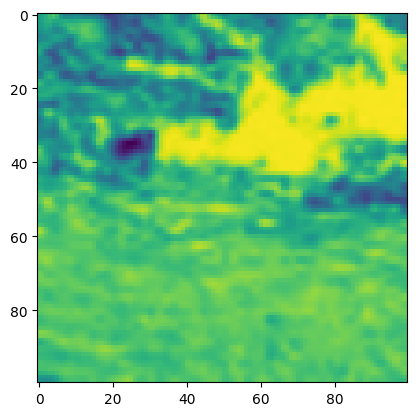


 Après la couche de convolution et  pooling 

Couche 0


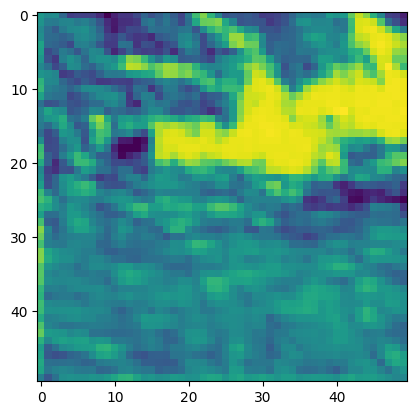

Couche 1


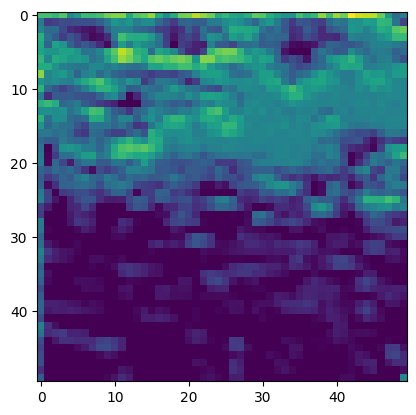

Couche 2


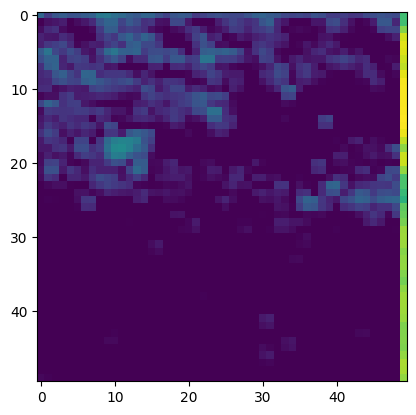

Couche 3


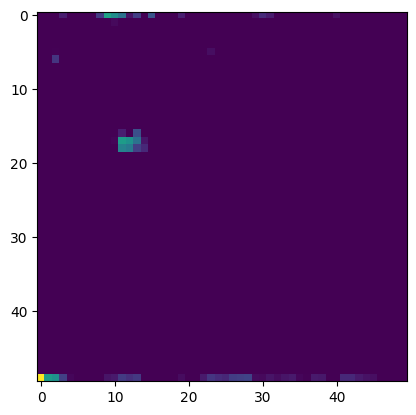

Couche 4


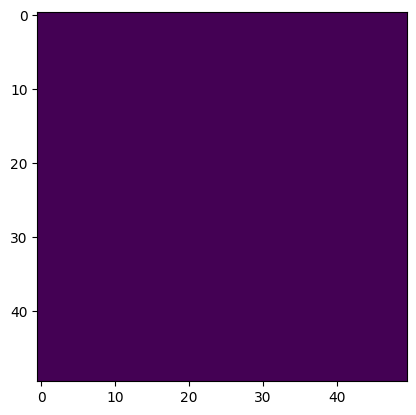

In [34]:
idx=1
z= next(iter(test_loader))[0].to(device)
print("Input Image")
# When plotting with matplotlib, it expects CPU numpy arrays, so we move it back to CPU for visualization
plt.imshow(z.cpu()[idx][0].detach().numpy())
plt.show()

print("\n Après la couche de convolution et  pooling \n")

for i in range(5):
  print(f'Couche {i}')
  # We also need to move the output of intermediate layers back to CPU for plotting
  plt.imshow(model1.pool1(nn.ReLU()(model1.conv1(z)))[idx].cpu().detach().numpy()[i])
  plt.show()

## Rapport de classification et matrice de confusion

In [35]:

#Evaluation du modèle
def evaluate_model(model, dataloader):
    model.eval()
    all_labels=[]
    all_predictions=[]
    all_probs=[]
    with torch.no_grad():
        for images, labels in dataloader:
          images,labels=images.to(device),labels.to(device)
          outputs = model(images)
          #pour la courbe ROC
          probs = torch.softmax(outputs, dim=1)[:,1]#clacul de proba
          all_probs.extend(probs.cpu().numpy())

          all_labels.extend(labels.cpu().numpy())
    all_probs=np.array(all_probs)
    all_labels=np.array(all_labels)
    fpr,tpr,seuils=roc_curve(all_labels,all_probs)
    meilleur_seuil=seuils[np.argmax(tpr-fpr)]
    predictions =(np.array(all_probs)>=meilleur_seuil).astype(int)
    roc_auc=auc(fpr,tpr)
    all_predictions.extend(predictions)
    print(classification_report(all_labels, all_predictions,digits=4))
    #matrice de confusion
    mc=confusion_matrix(all_labels,all_predictions)
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sns.heatmap(mc,annot=True,fmt='d')
    plt.xlabel("Prédictions")
    plt.ylabel("Réels")
    plt.title("Matrice de confusion")
    #courbe ROC
    plt.subplot(1,2,2)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (area = %0.4f)'%roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

##<font color="blue">Evaluations</font>

              precision    recall  f1-score   support

           0     0.9070    0.8417    0.8731       695
           1     0.6508    0.7736    0.7069       265

    accuracy                         0.8229       960
   macro avg     0.7789    0.8077    0.7900       960
weighted avg     0.8363    0.8229    0.8272       960



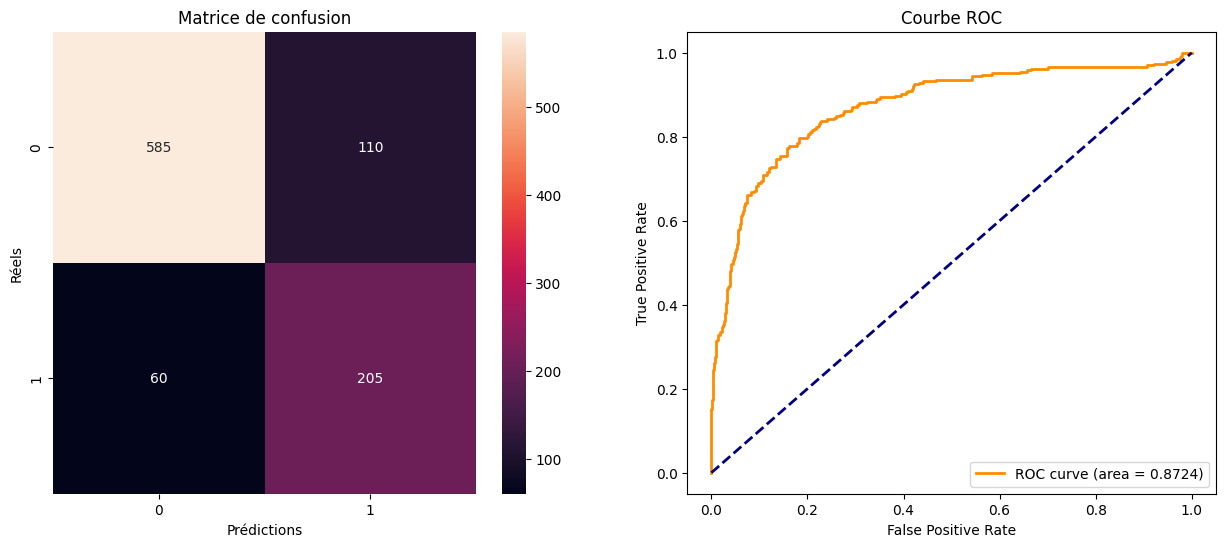

In [53]:
#Evaluation du premier modèle
evaluate_model(model1_1,test_loader)

              precision    recall  f1-score   support

           0     0.9299    0.8403    0.8828       695
           1     0.6657    0.8340    0.7404       265

    accuracy                         0.8385       960
   macro avg     0.7978    0.8371    0.8116       960
weighted avg     0.8570    0.8385    0.8435       960



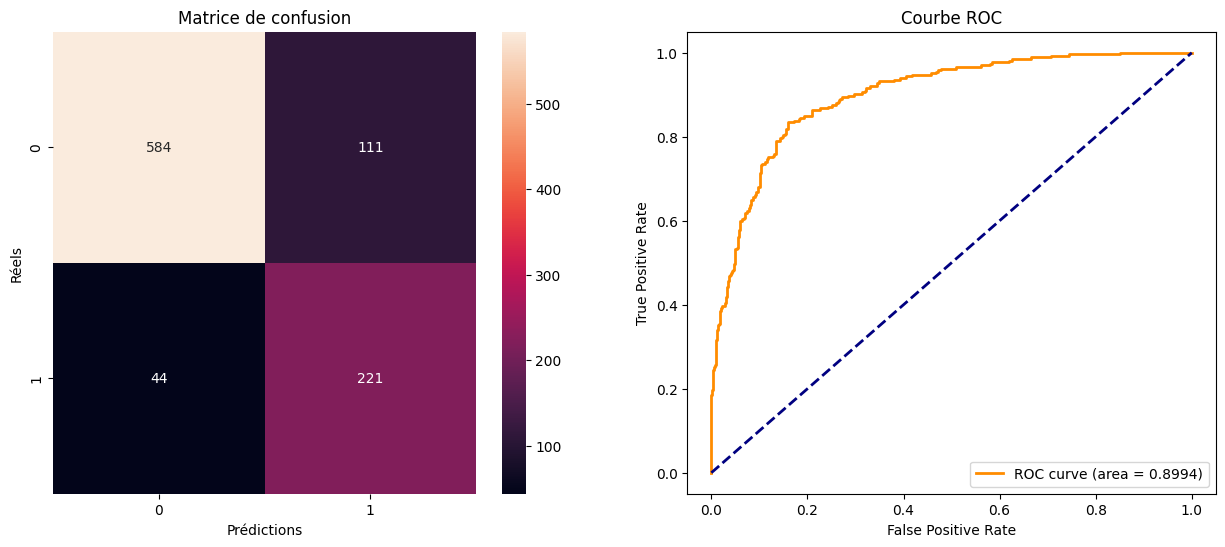

In [54]:
#evaluation du deuxième modèle
evaluate_model(model2_2,test_loader)

Premier constat : le modèle avec batchnormalisation semble être meilleur, meilleur recall, f1-score, et AUC.

**Normalisons les images**

In [55]:
#code pour déterminer mean et std
def mean_std(dataloader):
  mean=0.0
  std=0.0
  nb_samples=0
  for images,_ in dataloader:
    batch_samples=images.size(0)
    images=images.view(batch_samples,images.size(1),-1)
    mean+=images.mean(2).sum(0)
    std+=images.std(2).sum(0)
    nb_samples+=batch_samples
  mean/=nb_samples
  std/=nb_samples
  return mean,std


In [56]:
mean,std=mean_std(train_loader)

In [57]:
#Normalisation des images avec norme d'image net
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,
        std=std)])


Re Préparation des données

In [58]:
train_dataset1=CustumDataset(X_train,y_train,transform=transformation)
test_dataset1=CustumDataset(X_test,y_test,transform=transformation)
val_dataset1=CustumDataset(X_val,y_val,transform=transformation)

In [61]:
train_loader1=DataLoader(train_dataset1,batch_size=32,shuffle=True)
test_loader1=DataLoader(test_dataset1,batch_size=32,shuffle=False)
val_loader1=DataLoader(val_dataset1,batch_size=32,shuffle=False)

**Entrainons de nouveau après avoir normaliser nos images**

In [62]:
model1=CNN1(3).to(device)
model1_normalisé=train_validate(model1,train_loader1,val_loader1,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.4564 | Valid Loss: 0.4008
Epoch 2/50 | Train Loss: 0.4019 | Valid Loss: 0.3870
Epoch 3/50 | Train Loss: 0.3832 | Valid Loss: 0.3724
Epoch 4/50 | Train Loss: 0.3752 | Valid Loss: 0.4514
Epoch 5/50 | Train Loss: 0.3721 | Valid Loss: 0.3332
Epoch 6/50 | Train Loss: 0.3764 | Valid Loss: 0.3332
Epoch 7/50 | Train Loss: 0.3593 | Valid Loss: 0.3368
Epoch 8/50 | Train Loss: 0.3448 | Valid Loss: 0.3345
Epoch 9/50 | Train Loss: 0.3462 | Valid Loss: 0.3600
Epoch 10/50 | Train Loss: 0.3289 | Valid Loss: 0.3292
Epoch 11/50 | Train Loss: 0.3126 | Valid Loss: 0.3559
Epoch 12/50 | Train Loss: 0.3005 | Valid Loss: 0.3565
Epoch 13/50 | Train Loss: 0.2810 | Valid Loss: 0.3652
Epoch 14/50 | Train Loss: 0.2702 | Valid Loss: 0.3897
Epoch 15/50 | Train Loss: 0.2461 | Valid Loss: 0.4840
Early stopping 


<font color="blue">**Modèle 1**</font>

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.329294 

              precision    recall  f1-score   support

           0     0.9372    0.8374    0.8845       695
           1     0.6667    0.8528    0.7483       265

    accuracy                         0.8417       960
   macro avg     0.8019    0.8451    0.8164       960
weighted avg     0.8625    0.8417    0.8469       960



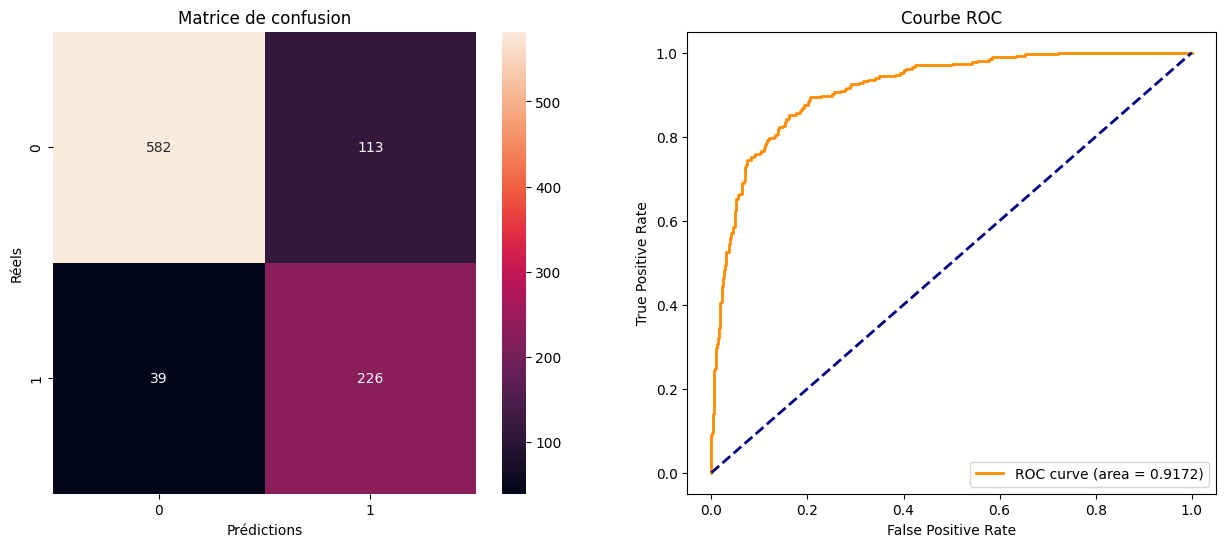

In [63]:
test_model(criterion,model1_normalisé,test_loader1)
evaluate_model(model1_normalisé,test_loader1)

Modèle 2

In [64]:
model2=CNN2(3).to(device)
model2_norm=train_validate(model2,train_loader1,val_loader1,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.7898 | Valid Loss: 0.4121
Epoch 2/50 | Train Loss: 0.4771 | Valid Loss: 0.3711
Epoch 3/50 | Train Loss: 0.4053 | Valid Loss: 0.3721
Epoch 4/50 | Train Loss: 0.4270 | Valid Loss: 0.3356
Epoch 5/50 | Train Loss: 0.3872 | Valid Loss: 0.3312
Epoch 6/50 | Train Loss: 0.3800 | Valid Loss: 0.3827
Epoch 7/50 | Train Loss: 0.3755 | Valid Loss: 0.3438
Epoch 8/50 | Train Loss: 0.3513 | Valid Loss: 0.3985
Epoch 9/50 | Train Loss: 0.3602 | Valid Loss: 0.3817
Epoch 10/50 | Train Loss: 0.3438 | Valid Loss: 0.3468
Early stopping 


Test Error: 
 Accuracy: 85.4%, Avg loss: 0.370937 

              precision    recall  f1-score   support

           0     0.9362    0.8029    0.8644       695
           1     0.6236    0.8566    0.7218       265

    accuracy                         0.8177       960
   macro avg     0.7799    0.8297    0.7931       960
weighted avg     0.8499    0.8177    0.8251       960



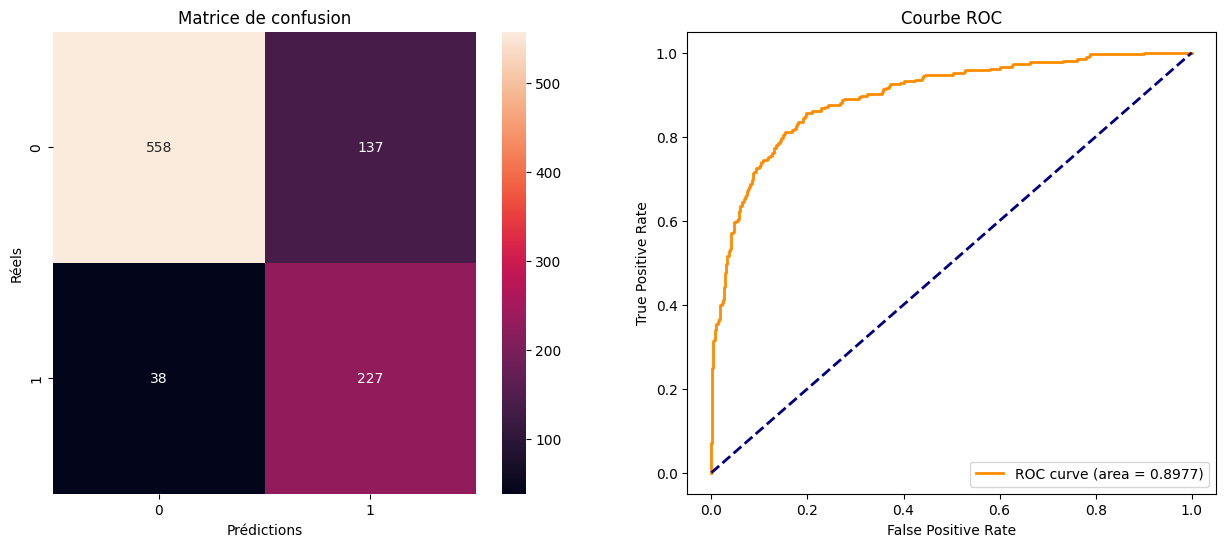

In [65]:
test_model(criterion,model2_norm,test_loader1)
evaluate_model(model2_norm,test_loader1)

<font color="blue">La Normalisation  des images semblent ne pas être  une mauvaise idée.</font>

## Interprétation :

<font color="blue">Interptétation de la matrice de confusion: L’analyse de la matrice de confusion et du rapport de classification montre que la classe 0 a un meilleur f1score, une meilleure précision
le modèle a tendance donc à mieux claaser la classe majoritaire, phénomène typique en présence d’un déséquilibre de classes.

Conclusion: hypothèse vérifiée
Résolutions:
- modifier la fonction perte en faisont en sorte que les erreurs sur la classe minoritaire coûtent plus cheres que celles sur la classe majoritaire.
- Entrainer le modèle en faisant de sorte que les images de la classe minoritaire apparaissent plus souvent dans l'entrainement.
- data augmentation</font>

<font color="purple">Alternative 1 : Modifier la fonction de perte en appliquant un poids plus élevé à la classe minoritaire. On opte pour le modèle 2 ie celui avec batchnormalisation pour la suite.</font>

In [118]:
#vu que notre modèle a tendance a mieux classer la classe majoritaire, on va faire de class weight loss
criterion1=nn.CrossEntropyLoss(weight=torch.tensor([1,3.5], dtype=torch.float).to(device))#les erreurs sur la classe 1 coûtent 2 fois plus cher que celles sur la classe

In [119]:
model2=CNN2(3).to(device)
model2_p=train_validate(model2,train_loader1,val_loader1,criterion1,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 1.0438 | Valid Loss: 0.5662
Epoch 2/50 | Train Loss: 0.5090 | Valid Loss: 0.4187
Epoch 3/50 | Train Loss: 0.4698 | Valid Loss: 0.3894
Epoch 4/50 | Train Loss: 0.4287 | Valid Loss: 0.3870
Epoch 5/50 | Train Loss: 0.4143 | Valid Loss: 0.3755
Epoch 6/50 | Train Loss: 0.4128 | Valid Loss: 0.3859
Epoch 7/50 | Train Loss: 0.4148 | Valid Loss: 0.3752
Epoch 8/50 | Train Loss: 0.4297 | Valid Loss: 0.3822
Epoch 9/50 | Train Loss: 0.4000 | Valid Loss: 0.4096
Epoch 10/50 | Train Loss: 0.3771 | Valid Loss: 0.4419
Epoch 11/50 | Train Loss: 0.3879 | Valid Loss: 0.3903
Epoch 12/50 | Train Loss: 0.3685 | Valid Loss: 0.3843
Early stopping 


In [120]:
test_model(criterion1,model2_p,test_loader1)

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.415068 



              precision    recall  f1-score   support

           0     0.9299    0.8403    0.8828       695
           1     0.6657    0.8340    0.7404       265

    accuracy                         0.8385       960
   macro avg     0.7978    0.8371    0.8116       960
weighted avg     0.8570    0.8385    0.8435       960



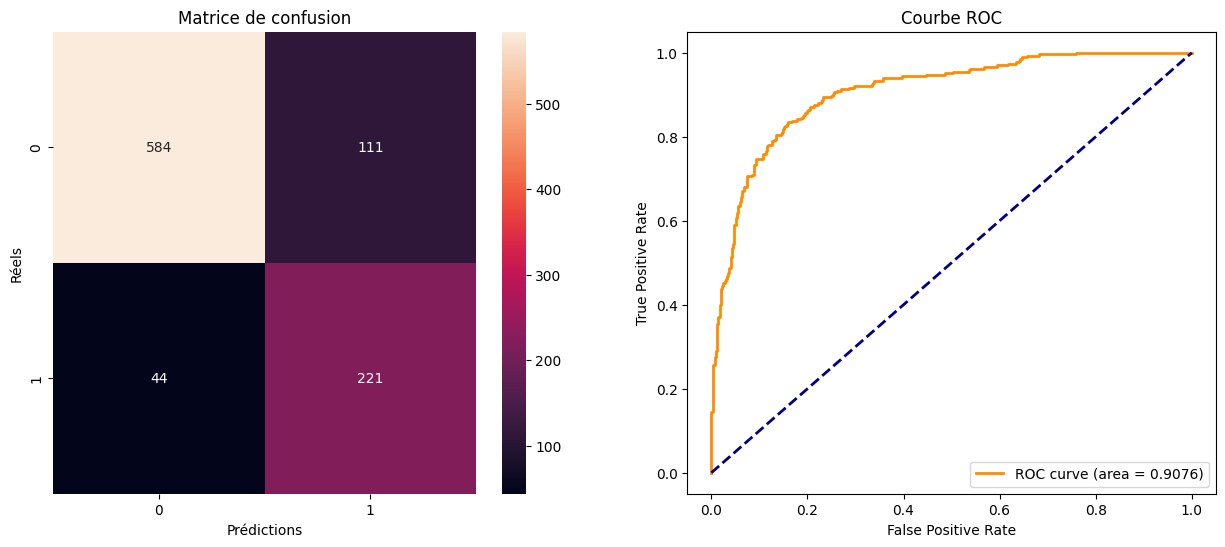

In [121]:
evaluate_model(model2_p,test_loader1)

<font color="blue">Conséquences :l'objectif étant de faire dimunier au mieux le faux négatif et de contrôler le faux positif nous allons procéder à une sélection de poids. En effet dans un contexte médical l'idéal serait d'éviter à tout prix les faux négatifs mais aussi éviter les fausses alertes. il apparait donc un complexe de choix de modèles</font>

### Sélection de poids optimal pour la class weight loss

In [122]:
#sélection de poids optimal
def sélection_de_poids(model,train_loader,val_loader,poids):
  for p in poids:
    criterion=nn.CrossEntropyLoss(weight=torch.tensor([1,p], dtype=torch.float).to(device))
    model_=train_validate(model,train_loader,val_loader,criterion,device,lr,n_epochs,patience)
    evaluate_model(model,val_loader)

Epoch 1/50 | Train Loss: 0.5537 | Valid Loss: 0.4045
Epoch 2/50 | Train Loss: 0.4495 | Valid Loss: 0.4031
Epoch 3/50 | Train Loss: 0.4321 | Valid Loss: 0.4147
Epoch 4/50 | Train Loss: 0.4260 | Valid Loss: 0.4012
Epoch 5/50 | Train Loss: 0.4123 | Valid Loss: 0.3965
Epoch 6/50 | Train Loss: 0.4139 | Valid Loss: 0.4151
Epoch 7/50 | Train Loss: 0.4005 | Valid Loss: 0.5469
Epoch 8/50 | Train Loss: 0.3761 | Valid Loss: 0.3985
Epoch 9/50 | Train Loss: 0.3827 | Valid Loss: 0.3828
Epoch 10/50 | Train Loss: 0.3707 | Valid Loss: 0.3757
Epoch 11/50 | Train Loss: 0.3542 | Valid Loss: 0.3907
Epoch 12/50 | Train Loss: 0.3625 | Valid Loss: 0.4041
Epoch 13/50 | Train Loss: 0.3173 | Valid Loss: 0.3802
Epoch 14/50 | Train Loss: 0.3182 | Valid Loss: 0.3835
Epoch 15/50 | Train Loss: 0.3083 | Valid Loss: 0.4086
Early stopping 
              precision    recall  f1-score   support

           0     0.9378    0.8245    0.8775       695
           1     0.6504    0.8566    0.7394       265

    accuracy       

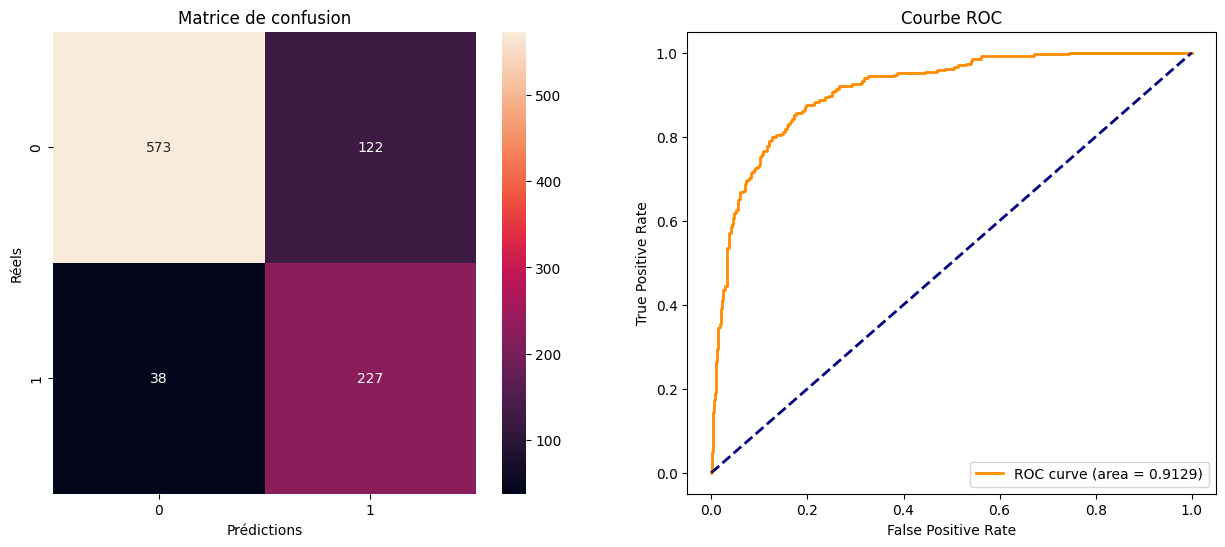

Epoch 1/50 | Train Loss: 0.4039 | Valid Loss: 0.4483
Epoch 2/50 | Train Loss: 0.4251 | Valid Loss: 0.5261
Epoch 3/50 | Train Loss: 0.4079 | Valid Loss: 0.4045
Epoch 4/50 | Train Loss: 0.3580 | Valid Loss: 0.4052
Epoch 5/50 | Train Loss: 0.3587 | Valid Loss: 0.4539
Epoch 6/50 | Train Loss: 0.3193 | Valid Loss: 0.5209
Epoch 7/50 | Train Loss: 0.2993 | Valid Loss: 0.4918
Epoch 8/50 | Train Loss: 0.3170 | Valid Loss: 0.4369
Early stopping 
              precision    recall  f1-score   support

           0     0.9202    0.8633    0.8909       695
           1     0.6916    0.8038    0.7435       265

    accuracy                         0.8469       960
   macro avg     0.8059    0.8335    0.8172       960
weighted avg     0.8571    0.8469    0.8502       960



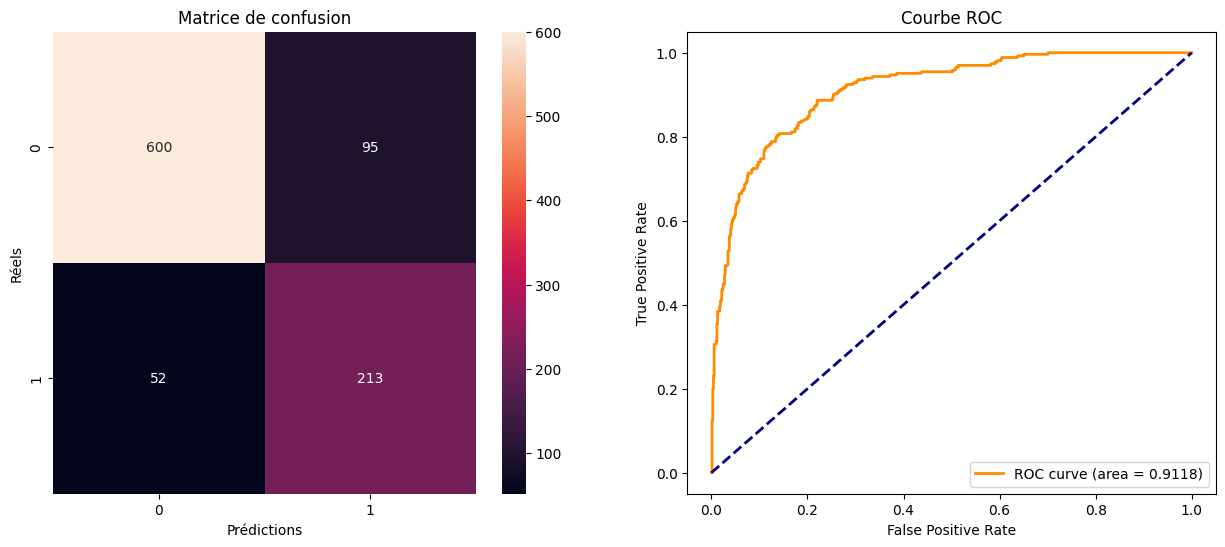

Epoch 1/50 | Train Loss: 0.3871 | Valid Loss: 0.3863
Epoch 2/50 | Train Loss: 0.3961 | Valid Loss: 0.4174
Epoch 3/50 | Train Loss: 0.3522 | Valid Loss: 0.5803
Epoch 4/50 | Train Loss: 0.3283 | Valid Loss: 0.5061
Epoch 5/50 | Train Loss: 0.2896 | Valid Loss: 0.5334
Epoch 6/50 | Train Loss: 0.3134 | Valid Loss: 0.4947
Early stopping 
              precision    recall  f1-score   support

           0     0.9365    0.8489    0.8906       695
           1     0.6818    0.8491    0.7563       265

    accuracy                         0.8490       960
   macro avg     0.8092    0.8490    0.8234       960
weighted avg     0.8662    0.8490    0.8535       960



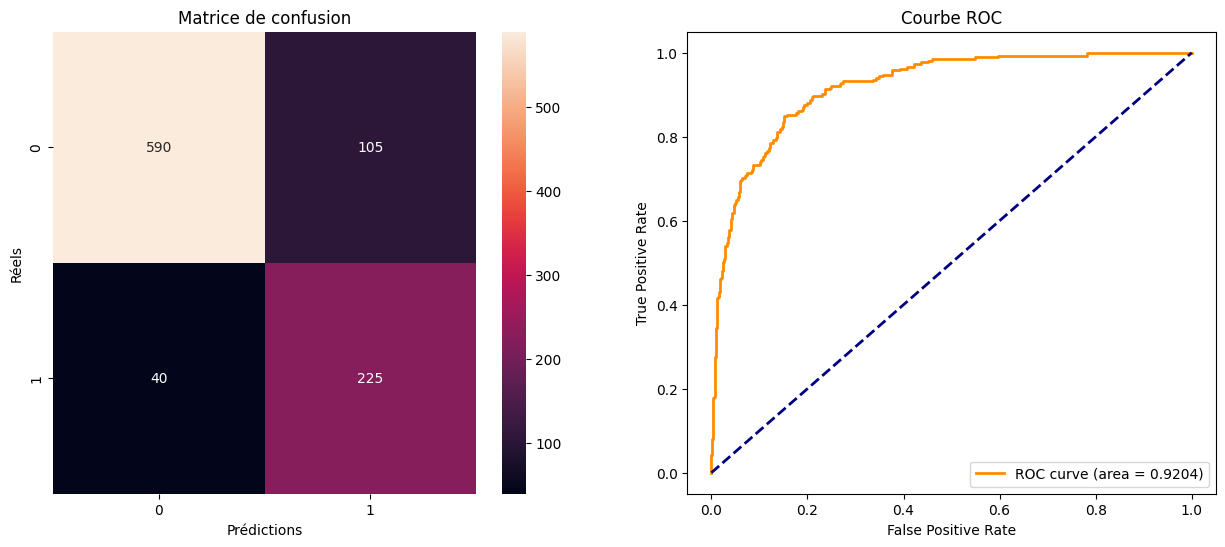

Epoch 1/50 | Train Loss: 0.4621 | Valid Loss: 0.4328
Epoch 2/50 | Train Loss: 0.3861 | Valid Loss: 0.3862
Epoch 3/50 | Train Loss: 0.3406 | Valid Loss: 0.6186
Epoch 4/50 | Train Loss: 0.3171 | Valid Loss: 0.4607
Epoch 5/50 | Train Loss: 0.3044 | Valid Loss: 0.4737
Epoch 6/50 | Train Loss: 0.3039 | Valid Loss: 0.4547
Epoch 7/50 | Train Loss: 0.2930 | Valid Loss: 0.4628
Early stopping 
              precision    recall  f1-score   support

           0     0.9189    0.8964    0.9075       695
           1     0.7447    0.7925    0.7678       265

    accuracy                         0.8677       960
   macro avg     0.8318    0.8444    0.8377       960
weighted avg     0.8708    0.8677    0.8689       960



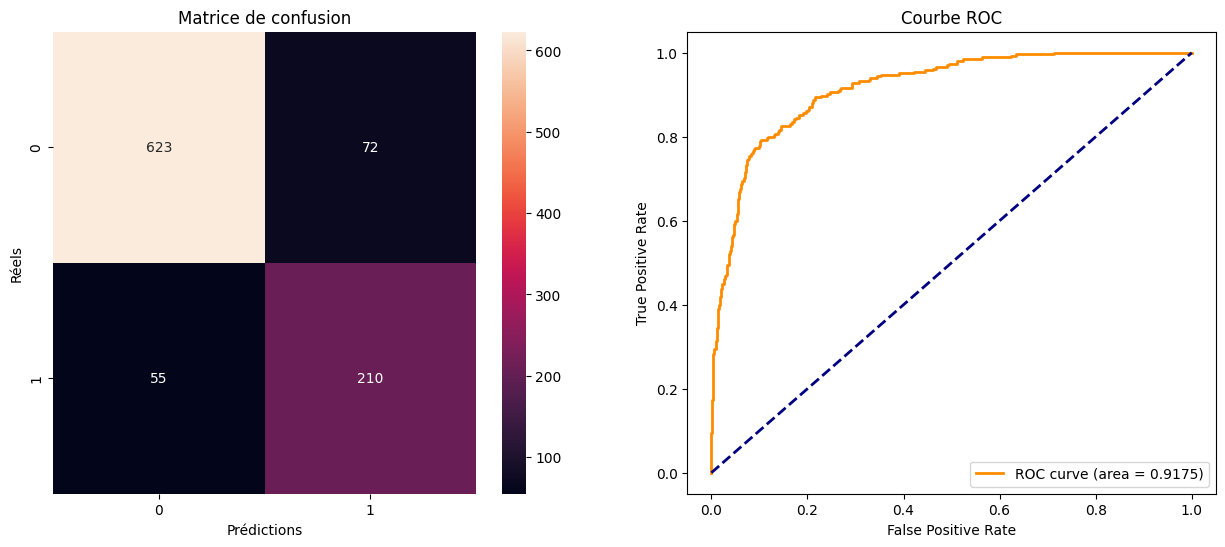

Epoch 1/50 | Train Loss: 0.4227 | Valid Loss: 0.4408
Epoch 2/50 | Train Loss: 0.3477 | Valid Loss: 0.6461
Epoch 3/50 | Train Loss: 0.3393 | Valid Loss: 0.4864
Epoch 4/50 | Train Loss: 0.3173 | Valid Loss: 0.4297
Epoch 5/50 | Train Loss: 0.3173 | Valid Loss: 0.7048
Epoch 6/50 | Train Loss: 0.2886 | Valid Loss: 0.5236
Epoch 7/50 | Train Loss: 0.2838 | Valid Loss: 0.5748
Epoch 8/50 | Train Loss: 0.2726 | Valid Loss: 0.5651
Epoch 9/50 | Train Loss: 0.2332 | Valid Loss: 0.5608
Early stopping 
              precision    recall  f1-score   support

           0     0.9314    0.8403    0.8835       695
           1     0.6667    0.8377    0.7425       265

    accuracy                         0.8396       960
   macro avg     0.7990    0.8390    0.8130       960
weighted avg     0.8583    0.8396    0.8446       960



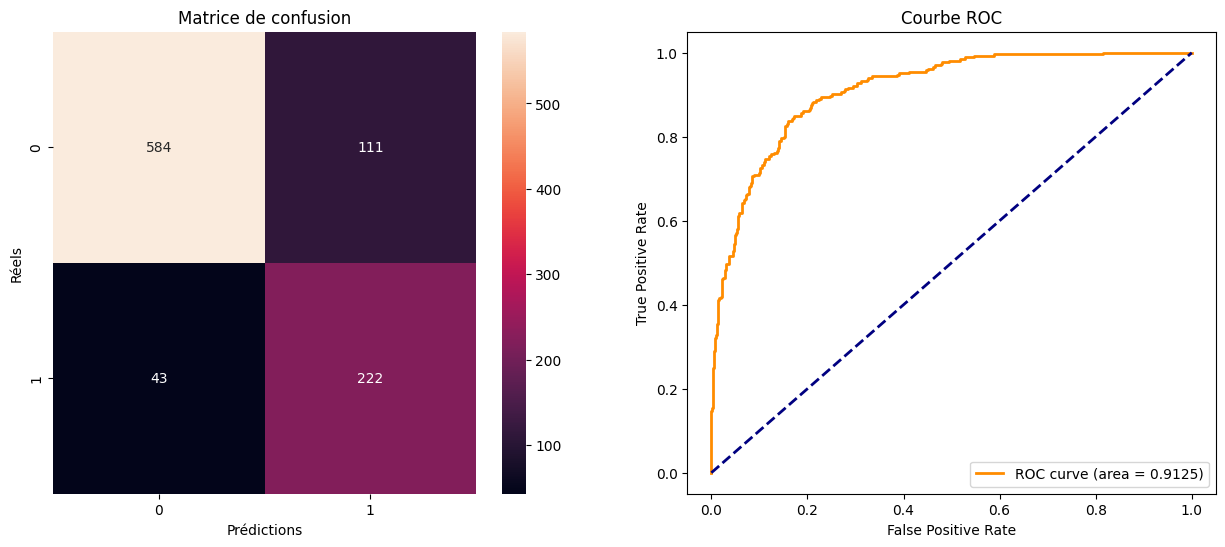

Epoch 1/50 | Train Loss: 0.3114 | Valid Loss: 0.7952
Epoch 2/50 | Train Loss: 0.3125 | Valid Loss: 0.5642
Epoch 3/50 | Train Loss: 0.3749 | Valid Loss: 0.5167
Epoch 4/50 | Train Loss: 0.3334 | Valid Loss: 0.4601
Epoch 5/50 | Train Loss: 0.2890 | Valid Loss: 0.6353
Epoch 6/50 | Train Loss: 0.2907 | Valid Loss: 0.5429
Epoch 7/50 | Train Loss: 0.2970 | Valid Loss: 0.8484
Epoch 8/50 | Train Loss: 0.2582 | Valid Loss: 0.5462
Epoch 9/50 | Train Loss: 0.2463 | Valid Loss: 0.5409
Early stopping 
              precision    recall  f1-score   support

           0     0.9337    0.8101    0.8675       695
           1     0.6303    0.8491    0.7235       265

    accuracy                         0.8208       960
   macro avg     0.7820    0.8296    0.7955       960
weighted avg     0.8499    0.8208    0.8277       960



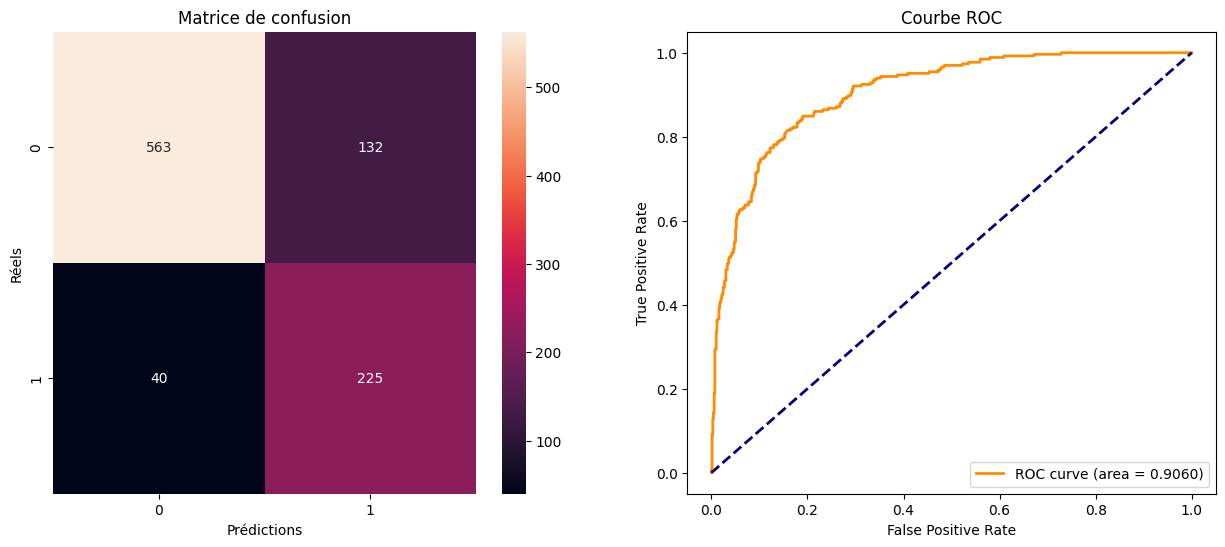

In [106]:
poids=[1.5,2,2.5,3.5,4,4.5]
sélection_de_poids(model2,train_loader1,test_loader1,poids)

<font color="blue">le poids idéal est celui qui a les meilleure recall, f1-score  et aussi une bonne AUC(Aire sous la courbe ROC), il semble que celui ci varie après chaque entrainement</font>

Alternative 2 : Entrainement en faisant apparaitre plus souvent la classe minoritaire

In [123]:
#Entrainement en faisant apparaitre plus souvent la classe minoritaire
label=np.array(train_dataset1.labels).astype(int)
class_counts=np.bincount(label)
class_weights = np.array([1.0/class_counts[0],3.0/class_counts[1]])
sample_weights=class_weights[label]
sample_weights=torch.DoubleTensor(sample_weights)
sampler=torch.utils.data.WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights),replacement=True)
train_loader_new=DataLoader(train_dataset1,batch_size=32,sampler=sampler)


In [127]:
model2=CNN2(3).to(device)
model_new=train_validate(model2,train_loader_new,val_loader1,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.6246 | Valid Loss: 1.0433
Epoch 2/50 | Train Loss: 0.4494 | Valid Loss: 0.7112
Epoch 3/50 | Train Loss: 0.3980 | Valid Loss: 0.5318
Epoch 4/50 | Train Loss: 0.4001 | Valid Loss: 0.8740
Epoch 5/50 | Train Loss: 0.3750 | Valid Loss: 0.6245
Epoch 6/50 | Train Loss: 0.3206 | Valid Loss: 0.5107
Epoch 7/50 | Train Loss: 0.3384 | Valid Loss: 0.4853
Epoch 8/50 | Train Loss: 0.2915 | Valid Loss: 0.6490
Epoch 9/50 | Train Loss: 0.3404 | Valid Loss: 0.5536
Epoch 10/50 | Train Loss: 0.3001 | Valid Loss: 0.7162
Epoch 11/50 | Train Loss: 0.3063 | Valid Loss: 0.5335
Epoch 12/50 | Train Loss: 0.2636 | Valid Loss: 0.6164
Early stopping 


In [128]:
test_model(criterion,model_new,test_loader1)

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.463965 



              precision    recall  f1-score   support

           0     0.9412    0.8288    0.8814       695
           1     0.6580    0.8642    0.7471       265

    accuracy                         0.8385       960
   macro avg     0.7996    0.8465    0.8143       960
weighted avg     0.8630    0.8385    0.8443       960



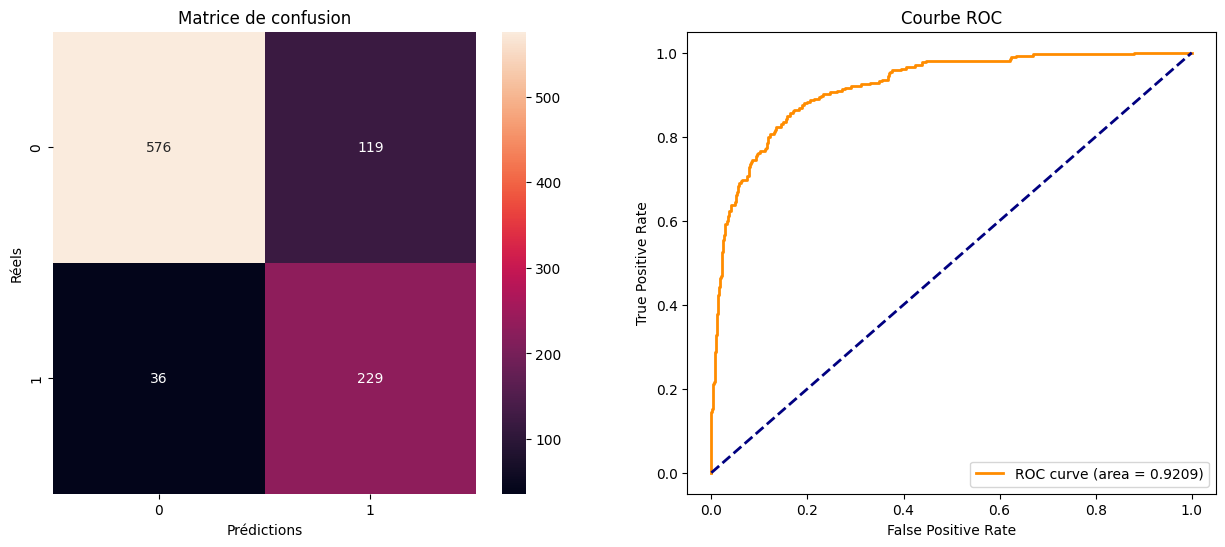

In [129]:
evaluate_model(model_new,test_loader1)

<font color="blue">Cette alternative augmente également le reacll de la classe IDC+ ce qui nous arrange, il faudrait optimisez ici aussi le poids pour l'apparution de la classe minoritaire.</font>

<font color="purple">Alternative 3: Combiner la weight class loss et le sur échantillonnage de la classe minoritaire.</font>

In [131]:
#combiner class weight loss  entrainement de sorte que la classe minoritaire apparaisse plus souvent
criterion1=nn.CrossEntropyLoss(weight=torch.tensor([1,3.5], dtype=torch.float).to(device))
model2=CNN2(3).to(device)
model_new_combiné=train_validate(model2,train_loader_new,val_loader1,criterion1,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.4399 | Valid Loss: 1.1198
Epoch 2/50 | Train Loss: 0.2415 | Valid Loss: 0.7480
Epoch 3/50 | Train Loss: 0.2274 | Valid Loss: 0.5526
Epoch 4/50 | Train Loss: 0.2241 | Valid Loss: 0.7362
Epoch 5/50 | Train Loss: 0.2048 | Valid Loss: 0.7273
Epoch 6/50 | Train Loss: 0.1858 | Valid Loss: 0.6975
Epoch 7/50 | Train Loss: 0.1704 | Valid Loss: 0.6195
Epoch 8/50 | Train Loss: 0.1733 | Valid Loss: 0.5881
Early stopping 


In [132]:
test_model(criterion1,model_new_combiné,test_loader1)

Test Error: 
 Accuracy: 72.1%, Avg loss: 0.528999 



              precision    recall  f1-score   support

           0     0.9118    0.8921    0.9018       695
           1     0.7321    0.7736    0.7523       265

    accuracy                         0.8594       960
   macro avg     0.8220    0.8328    0.8271       960
weighted avg     0.8622    0.8594    0.8605       960



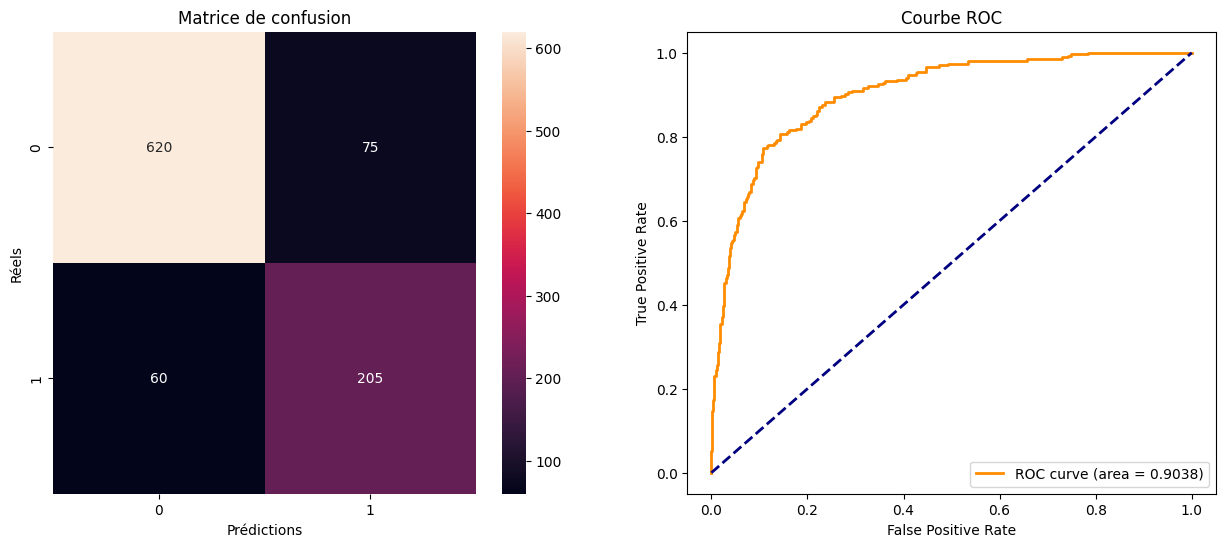

In [133]:
evaluate_model(model_new_combiné,test_loader1)

<font color="blue">L’ajustement des poids dans la fonction de perte permet de mieux classer la classe minoritaire en réduisant les faux négatifs. La sur-représentation de cette classe améliore également les performances.La combinaison des deux méthodes semblent donner de bon resultats aussi(bon f1 score pour la classe 1). Malgré les gains obtenus sur les faux négatifs, nous n’arrivons pas encore à contrôler efficacement les faux positifs. Ainsi, l’usage de poids adaptés combiné à une stratégie de rééquilibrage serait la solution a envisagé à ce stade car il équilibre les FN et FP</font>

Affichage de quelques images avec grad cam sur notre modèle.

In [23]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 137.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; pytho

In [24]:
import torch.nn.functional as F
from torchvision.transforms import InterpolationMode
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM


In [25]:
N=10
indices=np.random.choice(len(test_dataset),N,replace=False)#choix aléatoire d'indices
#fonction d'affichage
def gradcam_affiche(model,dataset,device,targets):
  image_transform = transforms.ToTensor()
  dataset=CustumDataset(X_test,y_test,transform=image_transform)
  model.eval()
  model.to(device)
  fig,axes=plt.subplots(N,len(targets)+1,figsize=(20,5*N))
  for i,idx in enumerate(indices):
    images,labels=dataset[idx]
    img_pil=to_pil_image(images)
    images=images.unsqueeze(0).to(device)
    #on affiche l'image originale
    axes[i,0].imshow(img_pil)
    axes[i,0].set_title(f"Image originale et label={labels}")
    #Grad CAM
    for j,target in enumerate(targets):
      cam_extractor=GradCAM(model,target_layer=target)
      output=model(images)
      class_predite=torch.argmax(output,dim=1).item()
      heatmap=cam_extractor(class_predite,output)[0]
      heatmap = F.relu(heatmap)
      if heatmap.max() > 0:
                heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

      heatmap=heatmap.cpu()

      # Resize heatmap to original image size and convert to PIL Image
      heatmap_resized = transforms.Resize(
                img_pil.size[::-1],
                interpolation=InterpolationMode.BICUBIC
            )(to_pil_image(heatmap, mode='F'))
      cam_image = overlay_mask(img_pil, heatmap_resized, alpha=0.1)
      axes[i,j+1].imshow(cam_image)
      if i==0:
        axes[i,j+1].set_title(target)
  plt.tight_layout()
  plt.show()


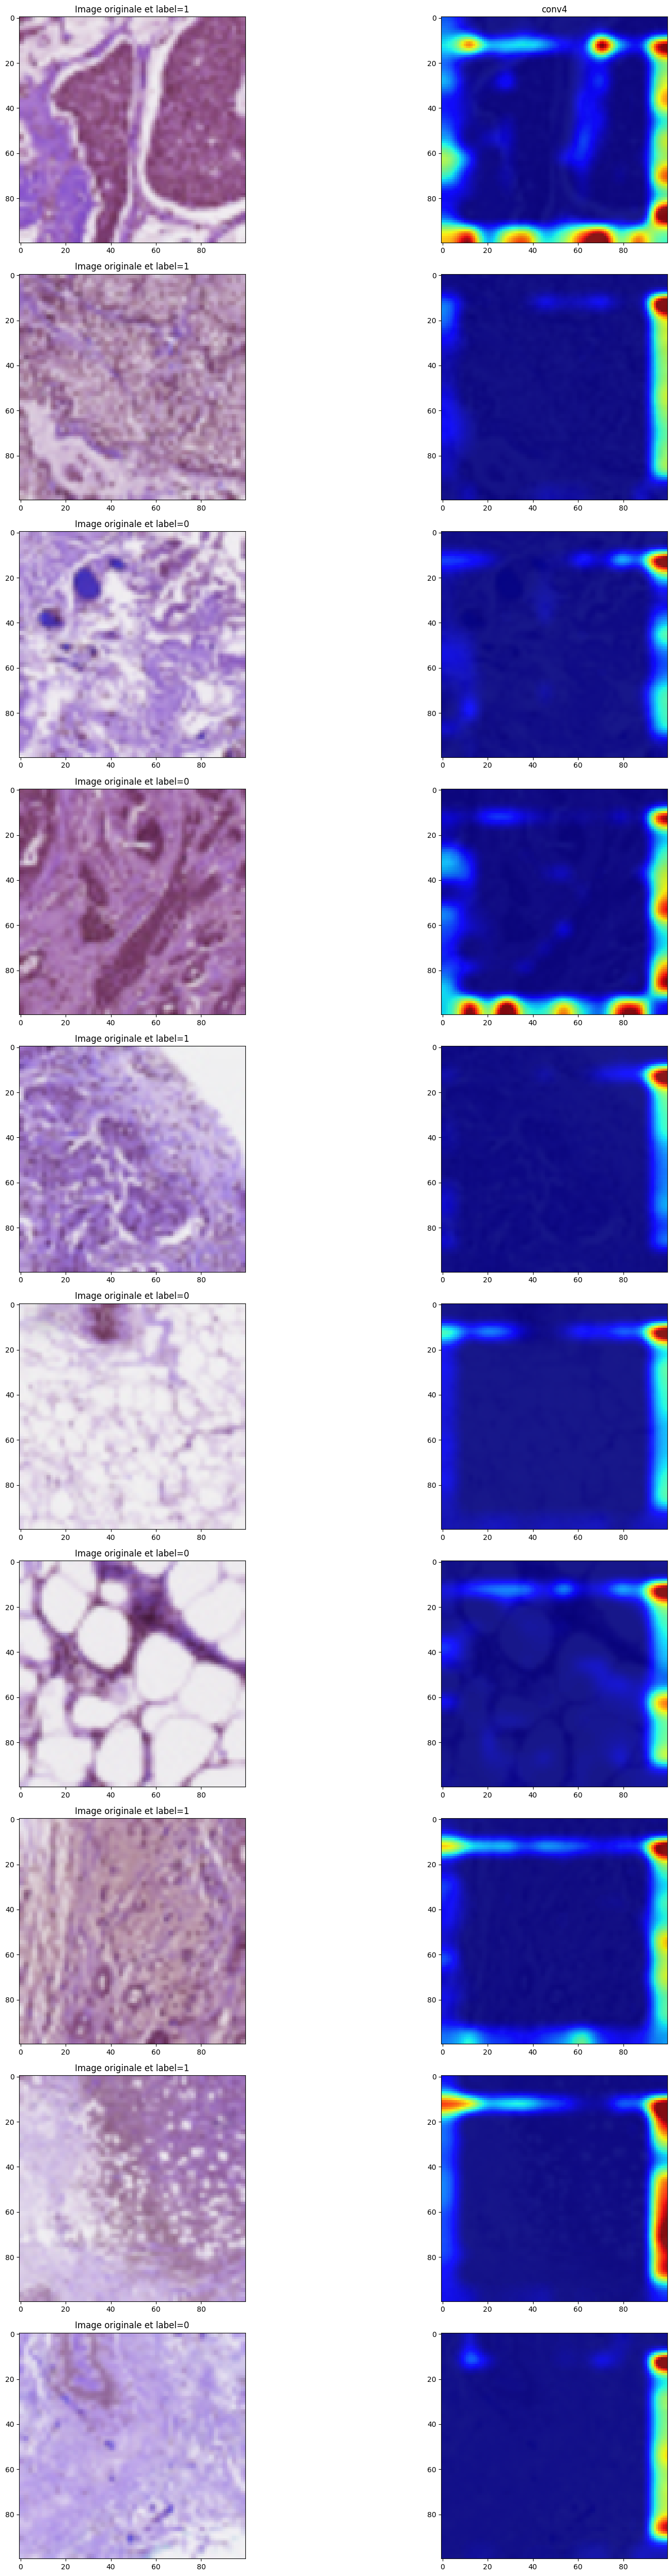

In [26]:
# On cible la dernière couche de convolution avant le pooling/flatten
targets = ["conv4"]
gradcam_affiche(model2, test_dataset, device, targets)

## Modèles pré entrainés

<font color="purple">Pour ce travail nous avons utilisés des modèles issus de deux grandes familles de modèles d'apprentissage profond que sont **ResNet** et **EfficientNet**.
- *Residual Network* en abrégé ResNet est une architecture d'apprentissage profond développé en 2015 par des chercheurs de microsoft qui la particularité d'utiliser des connexions résiduelles ou connexions raccourcies qui permettent au modèle de sauter ou contourner certaines étapes du processus d'apprentissage c'est à dire, au lieu de forcer le modèle à faire l'information par chaque couche ces raccourcis lui permettent de transmettre plus directement les détails importants et cela évite le phénomène de disparition du gradient.
- *EfficientNet* est une architecture d'apprentissage profond développé en 2019 par des chercheurs de GooglAI. Notons que avant EfficientNet pour améliorer la performance d'un modèle on ajustait les couches ce qui implique des modèles lourds et exigeants. EfficientNet utilise l'approche **mise à l'échelle composite**
qui consiste en gros à étendre la profondeur,largeur résolution tout en maintenant un certain équilibre. EfficientNet est un empilement de couches MBconv(MB pour MobileNet; convolution à goulot d'étranglements) et à l'intérieur de chaque MBconv il y a un module squeeze and excitation qui ajuste la force des différents canaux. Elle a la particularité d'utiliser une fonction d'activation *swish* qui apprend les motifs, et une régularisation stochastique.
</font>

In [134]:
#Exemples de modèles prèentrainés
from torchvision import models
#Resnet18
model_resnet18=models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_resnet18.fc=nn.Linear(model_resnet18.fc.in_features,2)
model_resnet18=model_resnet18.to(device)

train_transform = transforms.Compose([#on redimmensionne nos images car les modèles ont été entrainés sur des images de type IMAGENET
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )]
    )
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [135]:
train_dataset_pré=CustumDataset(X_train,y_train,transform=train_transform)#train_dataset_pré comme pour modèle pré entrainé
test_dataset_pré=CustumDataset(X_test,y_test,transform=test_transform)
val_dataset_pré=CustumDataset(X_val,y_val,transform=test_transform)
train_loader_pré=DataLoader(train_dataset_pré,batch_size=32,shuffle=True)
test_loader_pré=DataLoader(test_dataset_pré,batch_size=32,shuffle=False)
val_loader_pré=DataLoader(val_dataset_pré,batch_size=32,shuffle=False)
criterion=nn.CrossEntropyLoss()
model__resnet18=train_validate(model_resnet18,train_loader_pré,val_loader_pré,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.4656 | Valid Loss: 0.3920
Epoch 2/50 | Train Loss: 0.3555 | Valid Loss: 0.3950
Epoch 3/50 | Train Loss: 0.3431 | Valid Loss: 0.3139
Epoch 4/50 | Train Loss: 0.3302 | Valid Loss: 0.3140
Epoch 5/50 | Train Loss: 0.3192 | Valid Loss: 0.3137
Epoch 6/50 | Train Loss: 0.3064 | Valid Loss: 0.2929
Epoch 7/50 | Train Loss: 0.2946 | Valid Loss: 0.3534
Epoch 8/50 | Train Loss: 0.2857 | Valid Loss: 0.3018
Epoch 9/50 | Train Loss: 0.2475 | Valid Loss: 0.3459
Epoch 10/50 | Train Loss: 0.2045 | Valid Loss: 0.4099
Epoch 11/50 | Train Loss: 0.1924 | Valid Loss: 0.7527
Early stopping 


              precision    recall  f1-score   support

           0     0.9532    0.7914    0.8648       695
           1     0.6214    0.8981    0.7346       265

    accuracy                         0.8208       960
   macro avg     0.7873    0.8447    0.7997       960
weighted avg     0.8616    0.8208    0.8288       960



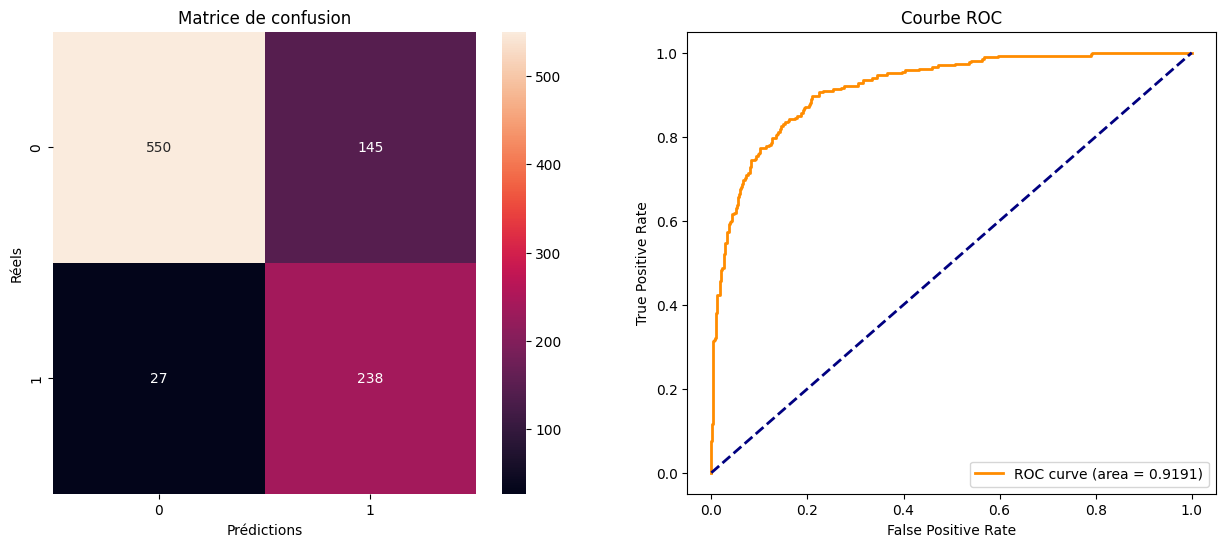

In [136]:
evaluate_model(model__resnet18,test_loader_pré)

In [137]:
#avec efficient net
model_efficientb0=models.efficientnet_b0(weights="IMAGENET1K_V1")
model_efficientb0.classifier[1]=nn.Linear(model_efficientb0.classifier[1].in_features,2)
model_efficientb0=model_efficientb0.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 226MB/s]


In [138]:
modèle_efficientB0=train_validate(model_efficientb0,train_loader_pré,val_loader_pré,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.4044 | Valid Loss: 0.3000
Epoch 2/50 | Train Loss: 0.3070 | Valid Loss: 0.3338
Epoch 3/50 | Train Loss: 0.2632 | Valid Loss: 0.2899
Epoch 4/50 | Train Loss: 0.2307 | Valid Loss: 0.3359
Epoch 5/50 | Train Loss: 0.1927 | Valid Loss: 0.2843
Epoch 6/50 | Train Loss: 0.1506 | Valid Loss: 0.3327
Epoch 7/50 | Train Loss: 0.1322 | Valid Loss: 0.3917
Epoch 8/50 | Train Loss: 0.0834 | Valid Loss: 0.4263
Epoch 9/50 | Train Loss: 0.1194 | Valid Loss: 0.4460
Epoch 10/50 | Train Loss: 0.0893 | Valid Loss: 0.5013
Early stopping 


              precision    recall  f1-score   support

           0     0.9613    0.8576    0.9065       695
           1     0.7088    0.9094    0.7967       265

    accuracy                         0.8719       960
   macro avg     0.8351    0.8835    0.8516       960
weighted avg     0.8916    0.8719    0.8762       960



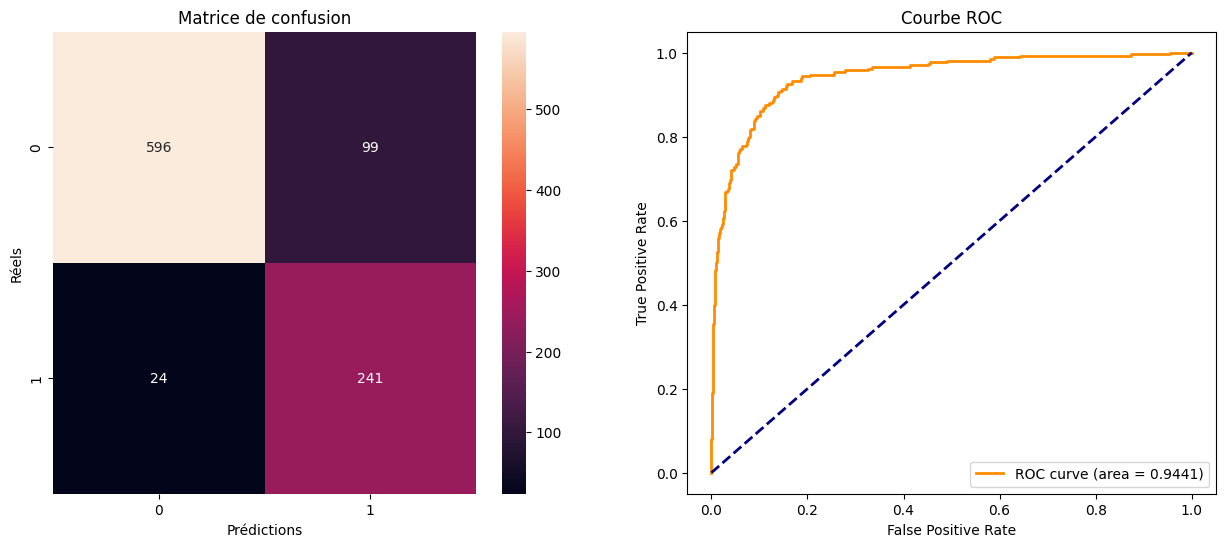

In [139]:
#evaluation du modèle pré entrainé Efficient net
evaluate_model(modèle_efficientB0,test_loader_pré)

In [140]:
#chargement de resnet50
model_resnet50=models.resnet50(weights="IMAGENET1K_V1")
model_resnet50.fc=nn.Linear(model_resnet50.fc.in_features,2)
model_resnet50=model_resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


In [142]:
model_Resnet50=train_validate(model_resnet50,train_loader_pré,val_loader_pré,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.3679 | Valid Loss: 0.3627
Epoch 2/50 | Train Loss: 0.3376 | Valid Loss: 0.4618
Epoch 3/50 | Train Loss: 0.3364 | Valid Loss: 0.2778
Epoch 4/50 | Train Loss: 0.3298 | Valid Loss: 0.3901
Epoch 5/50 | Train Loss: 0.3267 | Valid Loss: 0.3634
Epoch 6/50 | Train Loss: 0.3075 | Valid Loss: 0.3446
Epoch 7/50 | Train Loss: 0.2958 | Valid Loss: 0.3167
Epoch 8/50 | Train Loss: 0.2990 | Valid Loss: 0.3213
Early stopping 


              precision    recall  f1-score   support

           0     0.9289    0.8835    0.9056       695
           1     0.7291    0.8226    0.7730       265

    accuracy                         0.8667       960
   macro avg     0.8290    0.8530    0.8393       960
weighted avg     0.8737    0.8667    0.8690       960



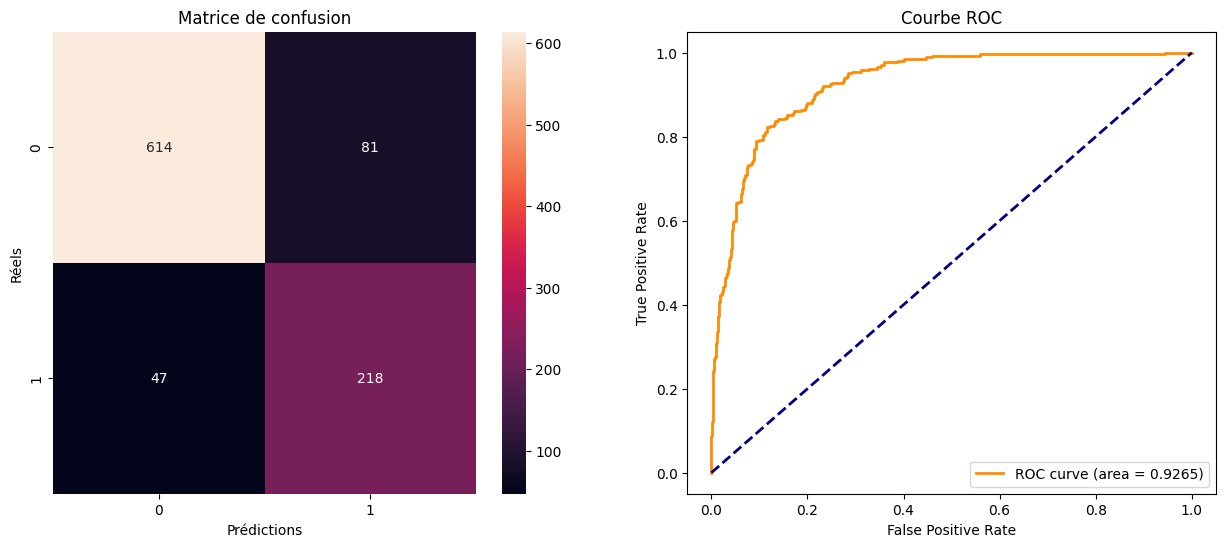

In [143]:
#evaluation
evaluate_model(model_Resnet50,test_loader_pré)

## Data augmentation

<font color="blue"> La précision et l'efficacité du deep learning dépendent de la qualité et la quantité des données d'apprentissage, or on est confronté très souvent à une insuffisance de données afin de palier à ce problème on accroit les données artificiellement la quantité des données, en faisant des modifications(orientations,luminosité... ): on diversifie l'ensemble d'apprentissage.</font>

In [149]:
#data augmentation ici on fait des modifications avec des orientations horizontales, verticales, rotations, luminosités et contraste, on peut bien sûr ajouter d'autres transformations
train_transform2=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),#rotation d'un angle de 10
    transforms.ColorJitter(brightness=0.4,contrast=0.9),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
train_dataset_pré2=CustumDataset(X_train,y_train,transform=train_transform2)
train_loader_aug=DataLoader(train_dataset_pré2,batch_size=32,shuffle=True)

<font color="blue">**Visualisation de l'effet de la data augmentation**</font>

In [145]:
def imshow(img):
    img = img / 2 + 0.5  # si normalisé entre [-1,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

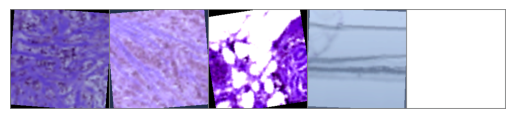

In [151]:
#visualisation data augmentation

import torchvision.utils
loader=DataLoader(train_dataset_pré2,batch_size=5,shuffle=True)
images,labels=next(iter(loader))
imshow(torchvision.utils.make_grid(images))

In [152]:
#entrainement de nouveau
model_resnet18_aug=train_validate(model_resnet18,train_loader_aug,val_loader_pré,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.4493 | Valid Loss: 0.3114
Epoch 2/50 | Train Loss: 0.4065 | Valid Loss: 0.3899
Epoch 3/50 | Train Loss: 0.4047 | Valid Loss: 0.5529
Epoch 4/50 | Train Loss: 0.4192 | Valid Loss: 0.3674
Epoch 5/50 | Train Loss: 0.3873 | Valid Loss: 0.3708
Epoch 6/50 | Train Loss: 0.3871 | Valid Loss: 0.2931
Epoch 7/50 | Train Loss: 0.3877 | Valid Loss: 0.4381
Epoch 8/50 | Train Loss: 0.3755 | Valid Loss: 0.3368
Epoch 9/50 | Train Loss: 0.3685 | Valid Loss: 0.2858
Epoch 10/50 | Train Loss: 0.3659 | Valid Loss: 0.2960
Epoch 11/50 | Train Loss: 0.3622 | Valid Loss: 0.3127
Epoch 12/50 | Train Loss: 0.3699 | Valid Loss: 0.3237
Epoch 13/50 | Train Loss: 0.3658 | Valid Loss: 0.3026
Epoch 14/50 | Train Loss: 0.3707 | Valid Loss: 0.2773
Epoch 15/50 | Train Loss: 0.3515 | Valid Loss: 0.2831
Epoch 16/50 | Train Loss: 0.3635 | Valid Loss: 0.2903
Epoch 17/50 | Train Loss: 0.3506 | Valid Loss: 0.3261
Epoch 18/50 | Train Loss: 0.3425 | Valid Loss: 0.2770
Epoch 19/50 | Train Loss: 0.3459 | Va

              precision    recall  f1-score   support

           0     0.9444    0.8302    0.8836       695
           1     0.6619    0.8717    0.7524       265

    accuracy                         0.8417       960
   macro avg     0.8031    0.8510    0.8180       960
weighted avg     0.8664    0.8417    0.8474       960



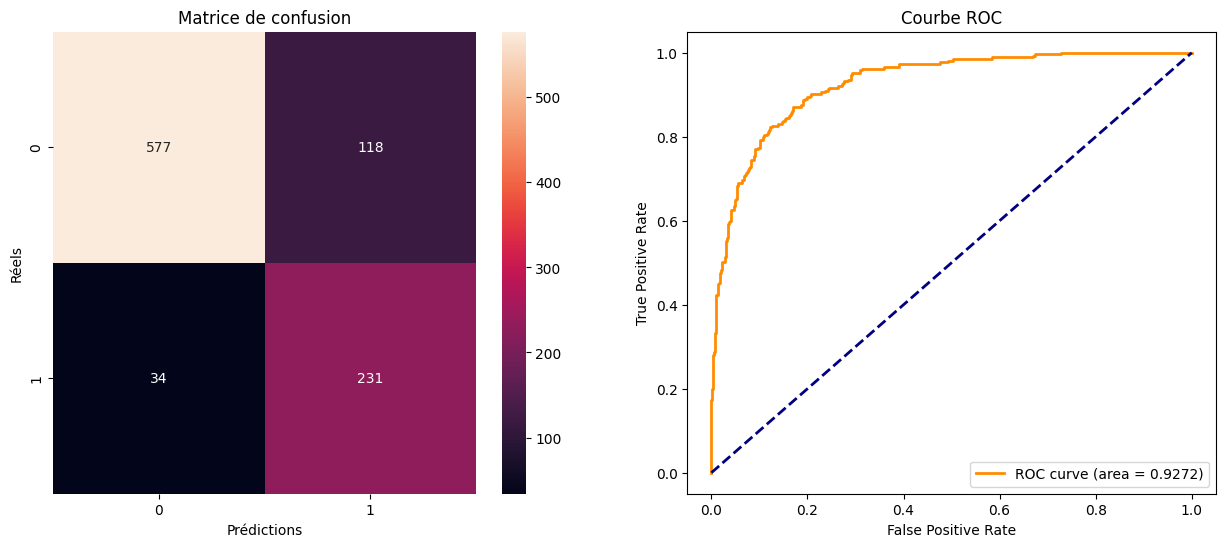

In [153]:
#evaluation de nouveau
evaluate_model(model_resnet18_aug,test_loader_pré)

EfficientNetB0

In [154]:
model_efficientB0_aug=train_validate(model_efficientb0,train_loader_aug,val_loader_pré,criterion,device,lr,n_epochs,patience)


Epoch 1/50 | Train Loss: 0.3972 | Valid Loss: 0.2751
Epoch 2/50 | Train Loss: 0.3568 | Valid Loss: 0.3207
Epoch 3/50 | Train Loss: 0.3493 | Valid Loss: 0.2537
Epoch 4/50 | Train Loss: 0.3343 | Valid Loss: 0.2623
Epoch 5/50 | Train Loss: 0.3156 | Valid Loss: 0.2718
Epoch 6/50 | Train Loss: 0.3058 | Valid Loss: 0.2496
Epoch 7/50 | Train Loss: 0.2940 | Valid Loss: 0.3420
Epoch 8/50 | Train Loss: 0.2866 | Valid Loss: 0.2435
Epoch 9/50 | Train Loss: 0.2795 | Valid Loss: 0.2737
Epoch 10/50 | Train Loss: 0.2736 | Valid Loss: 0.2615
Epoch 11/50 | Train Loss: 0.2617 | Valid Loss: 0.2546
Epoch 12/50 | Train Loss: 0.2540 | Valid Loss: 0.2956
Epoch 13/50 | Train Loss: 0.2424 | Valid Loss: 0.2706
Early stopping 


              precision    recall  f1-score   support

           0     0.9363    0.8878    0.9114       695
           1     0.7409    0.8415    0.7880       265

    accuracy                         0.8750       960
   macro avg     0.8386    0.8646    0.8497       960
weighted avg     0.8823    0.8750    0.8773       960



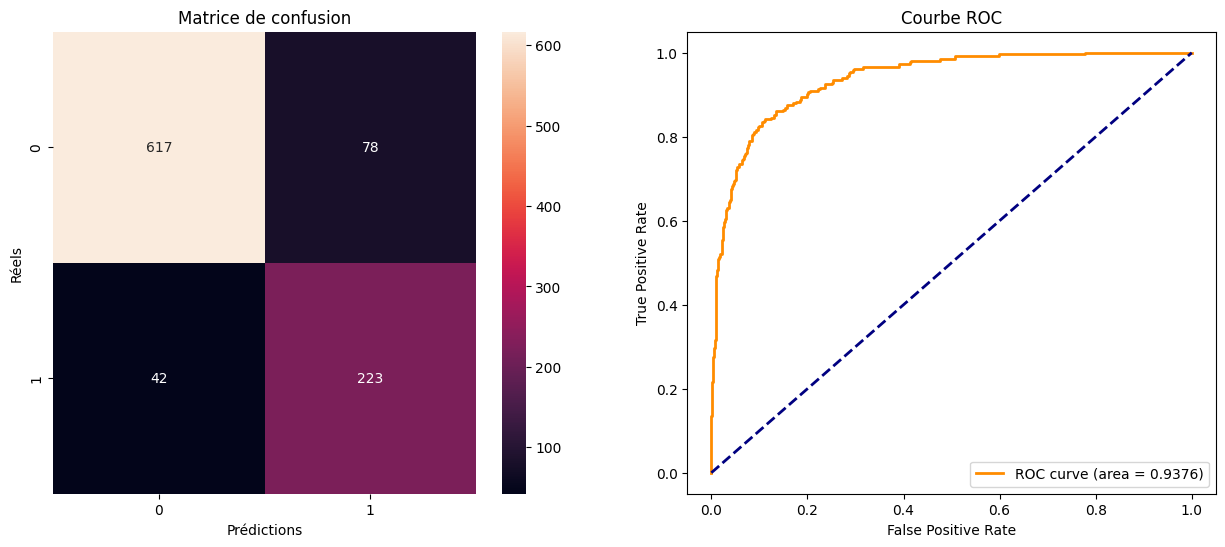

In [155]:
evaluate_model(model_efficientB0_aug,test_loader_pré)

Resnet 50

In [156]:
model_resnet50_aug=train_validate(model_resnet50,train_loader_aug,val_loader_pré,criterion,device,lr,n_epochs,patience)

Epoch 1/50 | Train Loss: 0.4576 | Valid Loss: 0.3401
Epoch 2/50 | Train Loss: 0.4186 | Valid Loss: 0.3122
Epoch 3/50 | Train Loss: 0.4037 | Valid Loss: 0.4949
Epoch 4/50 | Train Loss: 0.4058 | Valid Loss: 0.5363
Epoch 5/50 | Train Loss: 0.4146 | Valid Loss: 0.3236
Epoch 6/50 | Train Loss: 0.3951 | Valid Loss: 0.3060
Epoch 7/50 | Train Loss: 0.3865 | Valid Loss: 0.3363
Epoch 8/50 | Train Loss: 0.3803 | Valid Loss: 0.3110
Epoch 9/50 | Train Loss: 0.3817 | Valid Loss: 0.3601
Epoch 10/50 | Train Loss: 0.3762 | Valid Loss: 0.3495
Epoch 11/50 | Train Loss: 0.3829 | Valid Loss: 0.3150
Early stopping 


              precision    recall  f1-score   support

           0     0.9529    0.7856    0.8612       695
           1     0.6150    0.8981    0.7301       265

    accuracy                         0.8167       960
   macro avg     0.7839    0.8419    0.7956       960
weighted avg     0.8596    0.8167    0.8250       960



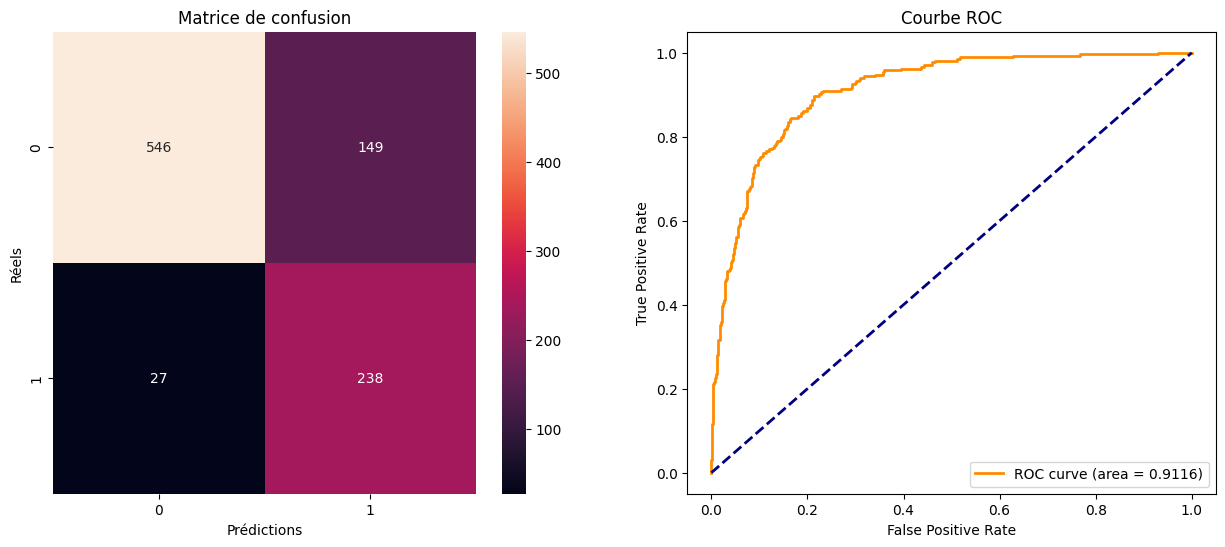

In [158]:
evaluate_model(model_resnet50_aug ,test_loader_pré)

Notre modèle

In [159]:
train_transform3=transforms.Compose([#on refait les mêmes transformations sauf la redimension des images car notre modèle n'a pas assez de pooling
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.9),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,
        std=std
    )
])
train_dataset_aug2=CustumDataset(X_train,y_train,transform=train_transform3)
train_loader_aug2=DataLoader(train_dataset_aug2,batch_size=32,shuffle=True)

In [160]:
model2 = CNN2(3).to(device)

model2_aug = train_validate(model2, train_loader_aug2, val_loader1, criterion, device, lr, n_epochs, patience)

Epoch 1/50 | Train Loss: 0.8910 | Valid Loss: 1.1709
Epoch 2/50 | Train Loss: 0.5405 | Valid Loss: 0.4111
Epoch 3/50 | Train Loss: 0.4762 | Valid Loss: 0.4295
Epoch 4/50 | Train Loss: 0.4789 | Valid Loss: 0.4125
Epoch 5/50 | Train Loss: 0.4895 | Valid Loss: 0.4229
Epoch 6/50 | Train Loss: 0.4694 | Valid Loss: 0.3905
Epoch 7/50 | Train Loss: 0.4694 | Valid Loss: 0.4163
Epoch 8/50 | Train Loss: 0.4833 | Valid Loss: 0.4045
Epoch 9/50 | Train Loss: 0.4729 | Valid Loss: 0.4220
Epoch 10/50 | Train Loss: 0.4919 | Valid Loss: 0.3817
Epoch 11/50 | Train Loss: 0.4848 | Valid Loss: 0.3670
Epoch 12/50 | Train Loss: 0.4861 | Valid Loss: 0.3860
Epoch 13/50 | Train Loss: 0.4752 | Valid Loss: 0.4119
Epoch 14/50 | Train Loss: 0.4742 | Valid Loss: 0.4340
Epoch 15/50 | Train Loss: 0.4733 | Valid Loss: 0.3591
Epoch 16/50 | Train Loss: 0.4750 | Valid Loss: 0.5352
Epoch 17/50 | Train Loss: 0.4638 | Valid Loss: 0.3639
Epoch 18/50 | Train Loss: 0.4583 | Valid Loss: 0.3509
Epoch 19/50 | Train Loss: 0.4632 | Va

              precision    recall  f1-score   support

           0     0.9157    0.8906    0.9030       695
           1     0.7324    0.7849    0.7577       265

    accuracy                         0.8615       960
   macro avg     0.8240    0.8378    0.8304       960
weighted avg     0.8651    0.8615    0.8629       960



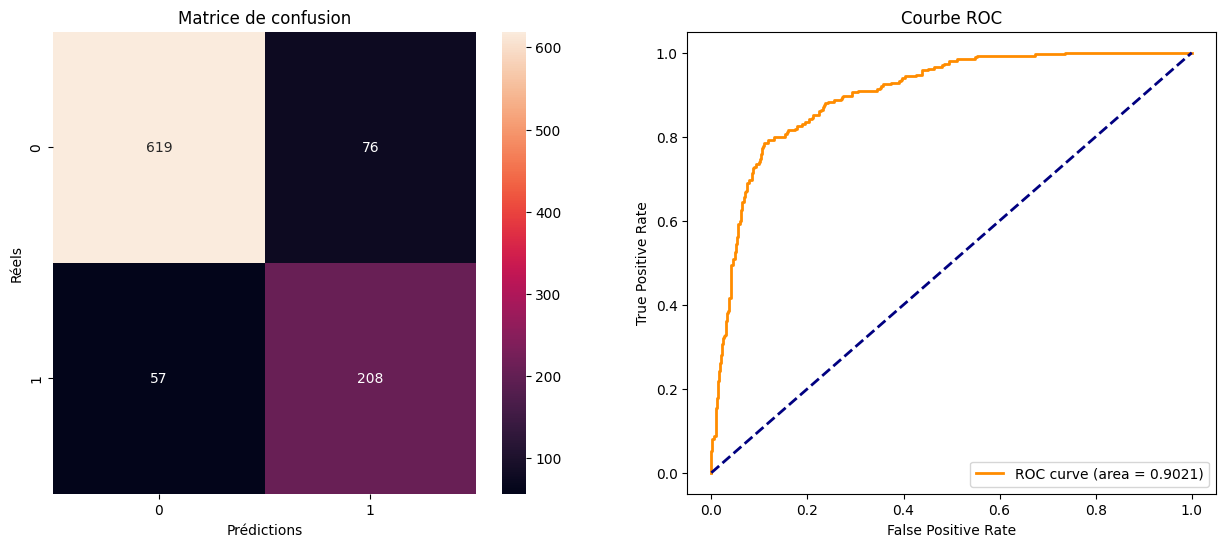

In [161]:
evaluate_model(model2_aug,test_loader1)

<font color="blue">Comme prévu il y a une amélioration( au sens du contrôle des FN et FP) des performances des modèles avec la data augmentation.</font>

## Seélection des hyperparamètres

In [163]:
from sklearn.metrics import recall_score, f1_score
import itertools

In [180]:
#définition d'une autre fonction d'entrainement-validation
def train_validate2(model,train_loader,val_loader,criterion,device,lr,n_epochs,patience, opti='adam'):#on défini une autre fonction train et validation car on veut choisir le meilleur modèle en fonction du recall,f1 score, valid loss
  # Choix de l'optimiseur
    if opti == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Nom de l'optimseur doit être 'adam'")
    best_val_loss = np.inf
    patience_counter = 0
    best_model = copy.deepcopy(model.state_dict())
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        train_loss = train_one_epoche(criterion, model, train_loader, device, optimizer)

        model.eval()
        val_loss = []
        y_true, y_pred = [], []
        with torch.no_grad():
            for x, y in val_loader:
                images, labels = x.to(device), y.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())

                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = np.mean(val_loss)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} -recall: {recall:.4f} - f1: {f1:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model)
    return model, recall, f1, best_val_loss

In [165]:
optis=["adam"]
patiences=[5,7,10]
lrs=[0.001]
batch_sizes=[32,64]
def selection_hyperparamètres(model,train_dataset,val_dataset,optis,lrs,n_epochs,patiences,device,batch_size):
  best_reacll=0
  best_config=None
  resultats=[]
  for lr,opti,batch_size,patience in itertools.product(lrs,optis,batch_sizes,patiences):
    print(f"\n On teste avec lr={lr},opti={opti},batch_size={batch_size},patience={patience}")
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)#on entraine
    val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)#on clacul la valid loss

    model=model.to(device)
    criterion=nn.CrossEntropyLoss()
    model,recall,f1,val_loss=train_validate2(model,train_loader,val_loader,criterion,device,lr,n_epochs,patience)
    result={"lr":lr,"opti":opti,"batch_size":batch_size,"patience":patience,"recall":recall,"f1":f1,"val_loss":val_loss}
    resultats.append(result)
    print(f"recall: {recall:.4f} - f1: {f1:.4f} - val_loss: {val_loss:.4f}")
    if recall>best_reacll:
      best_reacll=recall
      best_config=result
  return best_config,resultats

In [166]:
model2=CNN2(3).to(device)

In [167]:
#pour notre modéle
best_config,resultats=selection_hyperparamètres(model2,train_dataset,val_dataset,optis,lrs,n_epochs,patiences,device,batch_sizes)
print(f"Meilleure configuration: {best_config}")


 On teste avec lr=0.001,opti=adam,batch_size=32,patience=5
Epoch 1/50 - Train Loss: 0.6489 - Val Loss: 0.3492 -recall: 0.7273 - f1: 0.6906
Epoch 2/50 - Train Loss: 0.4318 - Val Loss: 0.4046 -recall: 0.6667 - f1: 0.7097
Epoch 3/50 - Train Loss: 0.4166 - Val Loss: 0.3767 -recall: 0.8333 - f1: 0.7483
Epoch 4/50 - Train Loss: 0.4077 - Val Loss: 0.3619 -recall: 0.6667 - f1: 0.7040
Epoch 5/50 - Train Loss: 0.4006 - Val Loss: 0.3447 -recall: 0.7576 - f1: 0.7353
Epoch 6/50 - Train Loss: 0.4081 - Val Loss: 0.3719 -recall: 0.5909 - f1: 0.6724
Epoch 7/50 - Train Loss: 0.3852 - Val Loss: 0.3276 -recall: 0.7121 - f1: 0.7344
Epoch 8/50 - Train Loss: 0.3757 - Val Loss: 0.5927 -recall: 0.5000 - f1: 0.6168
Epoch 9/50 - Train Loss: 0.3842 - Val Loss: 0.4459 -recall: 0.3333 - f1: 0.4835
Epoch 10/50 - Train Loss: 0.4028 - Val Loss: 0.3793 -recall: 0.6970 - f1: 0.7244
Epoch 11/50 - Train Loss: 0.3953 - Val Loss: 0.4058 -recall: 0.6818 - f1: 0.6977
Epoch 12/50 - Train Loss: 0.3851 - Val Loss: 0.3408 -recal

In [168]:
#réentrainement avec la meilleure configuration
train_loader_opt=DataLoader(train_dataset,batch_size=64,shuffle=True)
model2=CNN2(3).to(device)
model_opt=train_validate(model2,train_loader_opt,val_loader,criterion,device,lr,n_epochs,patience=7)

Epoch 1/50 | Train Loss: 0.6994 | Valid Loss: 0.7186
Epoch 2/50 | Train Loss: 0.4018 | Valid Loss: 0.4402
Epoch 3/50 | Train Loss: 0.4049 | Valid Loss: 0.4095
Epoch 4/50 | Train Loss: 0.3764 | Valid Loss: 0.3564
Epoch 5/50 | Train Loss: 0.3814 | Valid Loss: 0.4753
Epoch 6/50 | Train Loss: 0.3815 | Valid Loss: 0.3951
Epoch 7/50 | Train Loss: 0.3713 | Valid Loss: 0.3642
Epoch 8/50 | Train Loss: 0.3741 | Valid Loss: 0.6775
Epoch 9/50 | Train Loss: 0.3583 | Valid Loss: 0.4125
Epoch 10/50 | Train Loss: 0.3560 | Valid Loss: 0.5276
Epoch 11/50 | Train Loss: 0.3598 | Valid Loss: 0.4052
Early stopping 


              precision    recall  f1-score   support

           0     0.9258    0.8791    0.9018       695
           1     0.7200    0.8151    0.7646       265

    accuracy                         0.8615       960
   macro avg     0.8229    0.8471    0.8332       960
weighted avg     0.8690    0.8615    0.8640       960



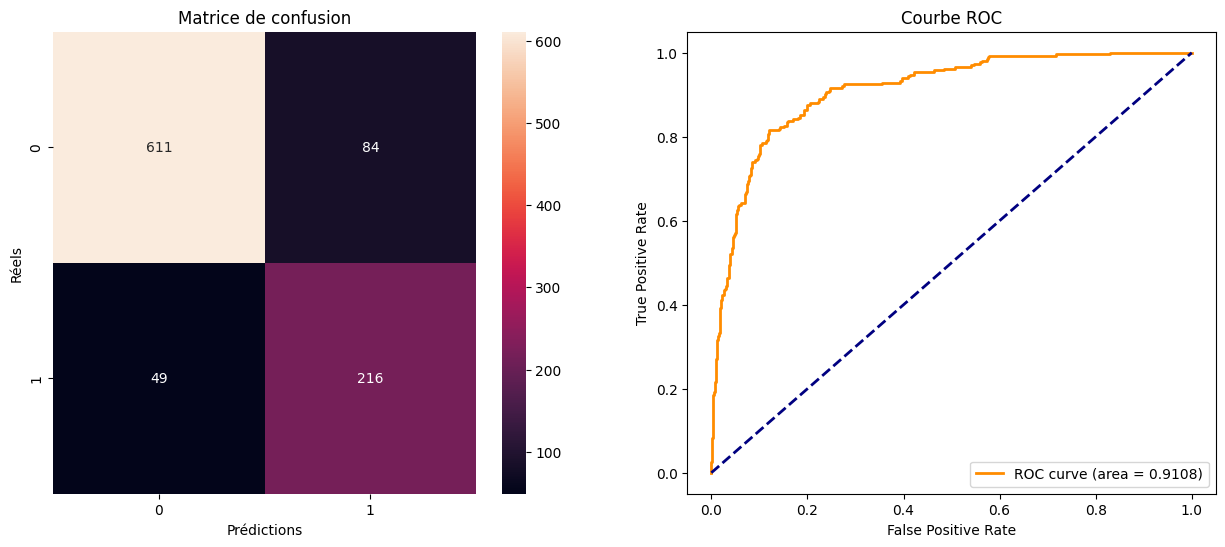

In [169]:
#réevaluation
evaluate_model(model_opt,test_loader)

In [170]:
#model efficientB0
best_config,resultats=selection_hyperparamètres(model_efficientb0,train_dataset_pré,val_dataset_pré,optis,lrs,n_epochs,patiences,device,batch_sizes)
print(f"Meilleure configuration: {best_config}")


 On teste avec lr=0.001,opti=adam,batch_size=32,patience=5
Epoch 1/50 - Train Loss: 0.2110 - Val Loss: 0.2795 -recall: 0.7879 - f1: 0.7879
Epoch 2/50 - Train Loss: 0.1530 - Val Loss: 0.2939 -recall: 0.8333 - f1: 0.8088
Epoch 3/50 - Train Loss: 0.0994 - Val Loss: 0.4311 -recall: 0.7727 - f1: 0.7786
Epoch 4/50 - Train Loss: 0.0714 - Val Loss: 0.5049 -recall: 0.8333 - f1: 0.7857
Epoch 5/50 - Train Loss: 0.0519 - Val Loss: 0.5835 -recall: 0.8182 - f1: 0.8060
Epoch 6/50 - Train Loss: 0.0544 - Val Loss: 0.6076 -recall: 0.8485 - f1: 0.7568
Early stopping at epoch 6
recall: 0.8485 - f1: 0.7568 - val_loss: 0.2795

 On teste avec lr=0.001,opti=adam,batch_size=32,patience=7
Epoch 1/50 - Train Loss: 0.1490 - Val Loss: 0.3266 -recall: 0.8788 - f1: 0.8286
Epoch 2/50 - Train Loss: 0.1040 - Val Loss: 0.3203 -recall: 0.8030 - f1: 0.8092
Epoch 3/50 - Train Loss: 0.0570 - Val Loss: 0.4709 -recall: 0.6667 - f1: 0.7586
Epoch 4/50 - Train Loss: 0.0643 - Val Loss: 0.6176 -recall: 0.6818 - f1: 0.7500
Epoch 5

In [171]:
#re entrainement avec la meilleure configuration
train_loader_opt2=DataLoader(train_dataset_pré,batch_size=64,shuffle=True)
model_efficientb0_opt=train_validate(model_efficientb0,train_loader_opt2,val_loader_pré,criterion,device,lr,n_epochs,patience)


Epoch 1/50 | Train Loss: 0.0319 | Valid Loss: 0.5879
Epoch 2/50 | Train Loss: 0.0184 | Valid Loss: 0.7125
Epoch 3/50 | Train Loss: 0.0265 | Valid Loss: 0.6395
Epoch 4/50 | Train Loss: 0.0311 | Valid Loss: 0.6420
Epoch 5/50 | Train Loss: 0.0185 | Valid Loss: 0.5850
Epoch 6/50 | Train Loss: 0.0081 | Valid Loss: 0.7201
Epoch 7/50 | Train Loss: 0.0271 | Valid Loss: 0.6358
Epoch 8/50 | Train Loss: 0.0237 | Valid Loss: 0.6656
Epoch 9/50 | Train Loss: 0.0244 | Valid Loss: 0.6581
Epoch 10/50 | Train Loss: 0.0100 | Valid Loss: 0.6371
Early stopping 


              precision    recall  f1-score   support

           0     0.9513    0.8705    0.9091       695
           1     0.7222    0.8830    0.7946       265

    accuracy                         0.8740       960
   macro avg     0.8367    0.8768    0.8518       960
weighted avg     0.8880    0.8740    0.8775       960



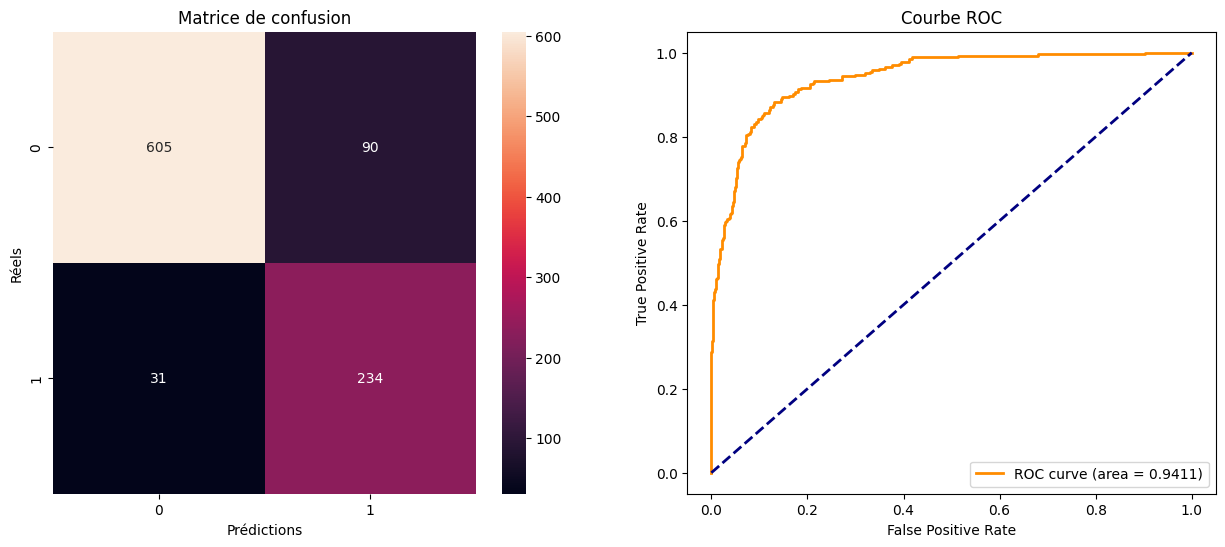

In [172]:
#evaluation
evaluate_model(model_efficientb0_opt,test_loader_pré)

## **Grad CAM pour les différents modèles**

<font color="blue">Grad-CAM (Gradient-weighted Class Activation Mapping) est une méthode qui permet de visualiser quelles zones d’une image ont le plus influencées la décision d’un réseau de neurones convolutionnel. Elle produit une carte de chaleur superposée à l’image originale, où les zones chaudes(rouges jaunes) indiquent les régions importantes pour la prédiction. Grad-CAM aide à comprendre si le modèle se concentre sur l’objet pertinent ou sur des éléments de fond.

**NB**: Notons qu'il s'agit d’un outil d’interprétation approximatif, qui montre où le modèle “regarde”, mais pas comment il raisonne réellement, en bref il ne faut pas seulement se baser sur GRAD-CAM.</font>

In [173]:
for name,param in model_resnet18.named_parameters():
  print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [174]:
for name,param in model_efficientb0.named_parameters():
  print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0.block.3.1.weight
features.2.0.block.3.1.bias
features.2.1.block.0.0.weight
features.2.1.block.0.1.weight
features.2.1.block.0.1.bias
features.2.1.block.1.0.weight
features.2.1.block.1.1.weight
features.2.1.block.1.1.bias
features.2.1.block.2.fc1.weight
features.2.1.block.2.fc1.bias
features.2.1.blo

In [175]:
for name,param in model_resnet50.named_parameters():
  print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

Grad CAM resnet 50

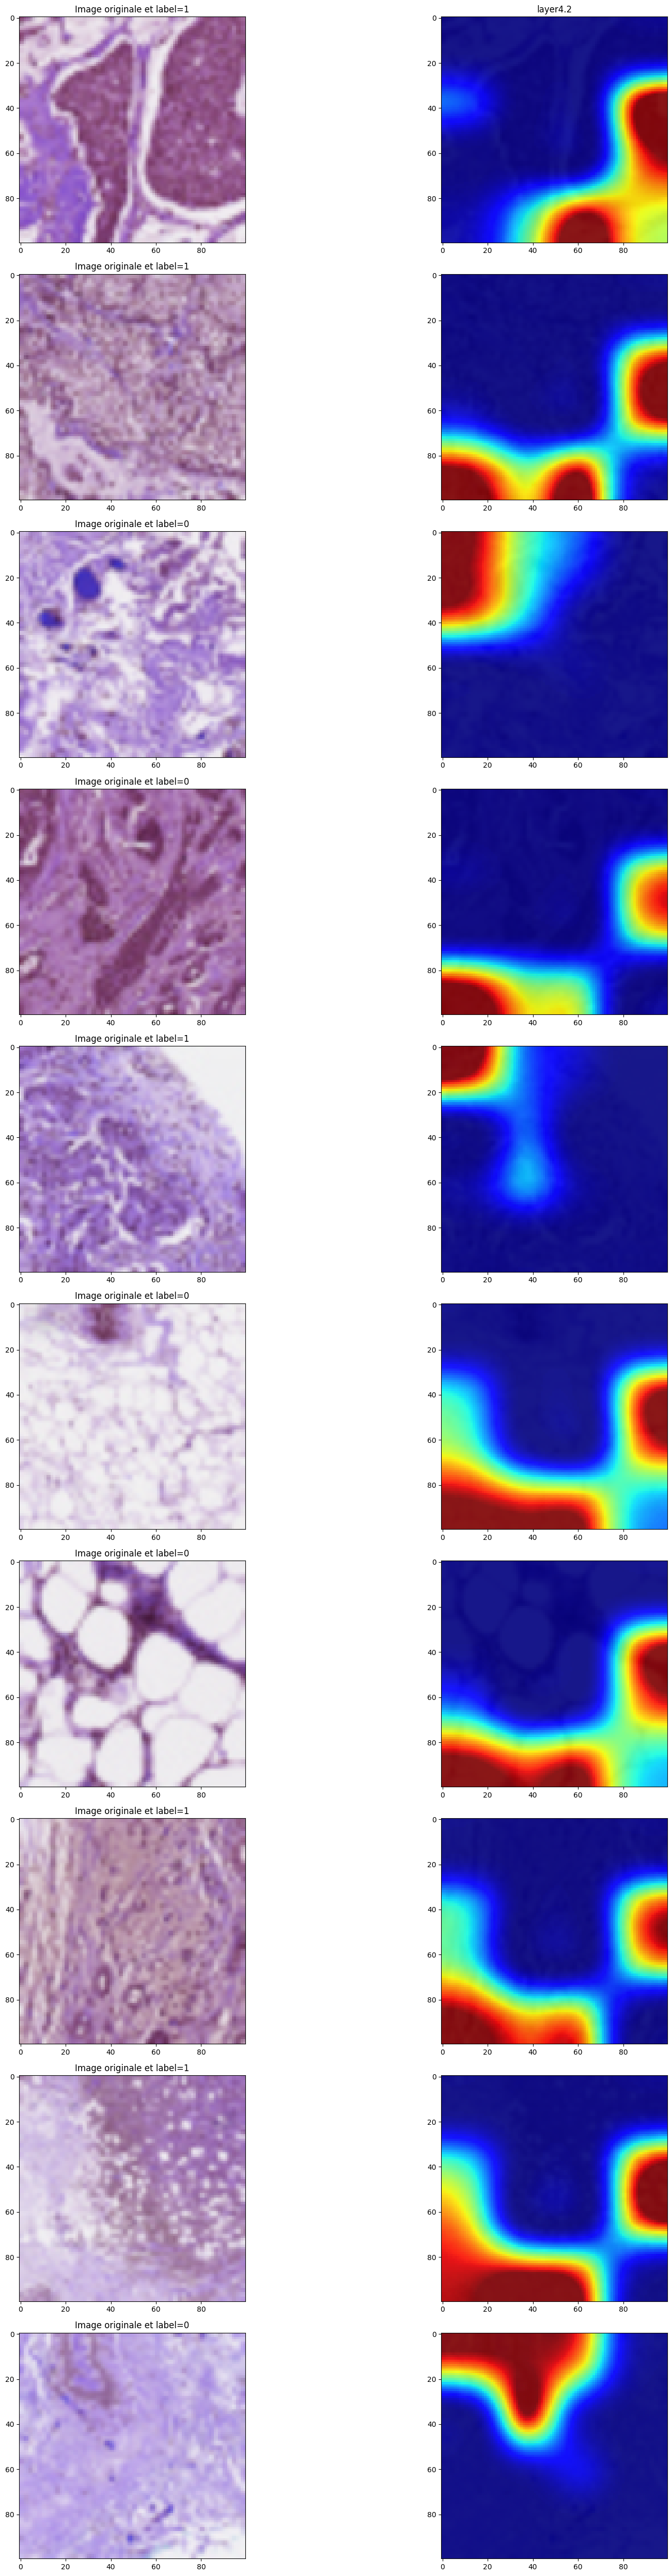

In [176]:
targets = ["layer4.2"]
gradcam_affiche(model_resnet50, test_dataset_pré, device, targets)

Grad CAM resnet 18

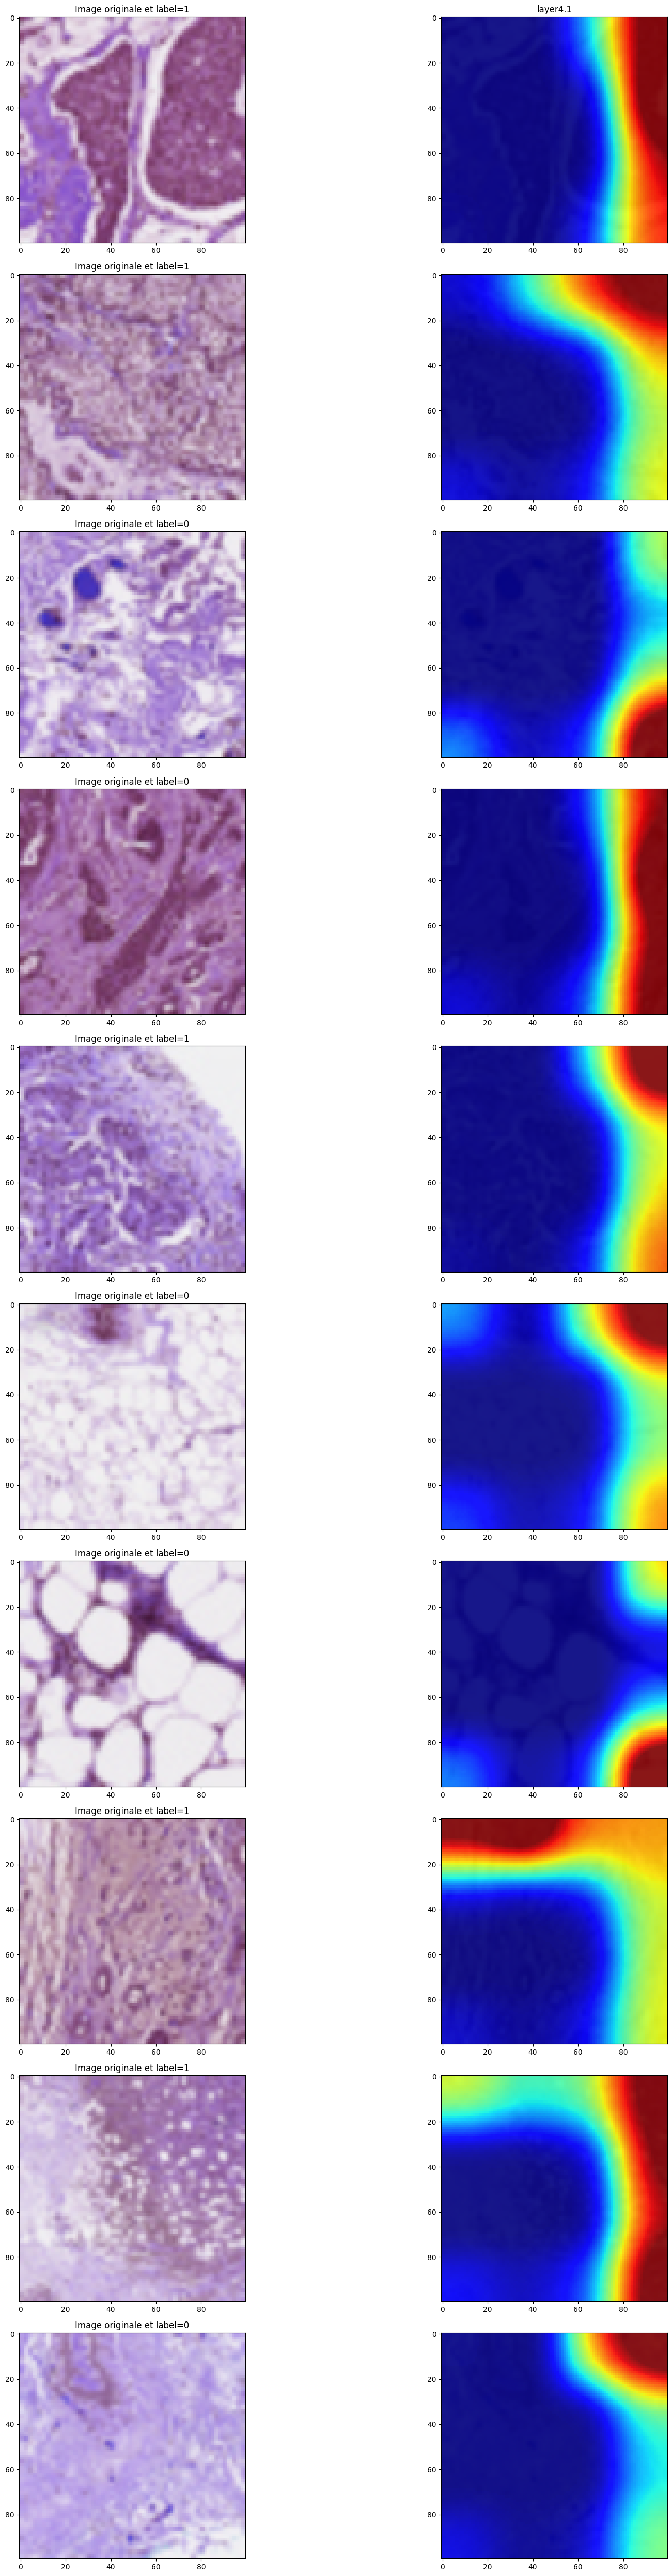

In [177]:
#grad cam resnet 18
targets = ["layer4.1"]
gradcam_affiche(model_resnet18, test_dataset_pré, device, targets)



Grad CAM efficientB0

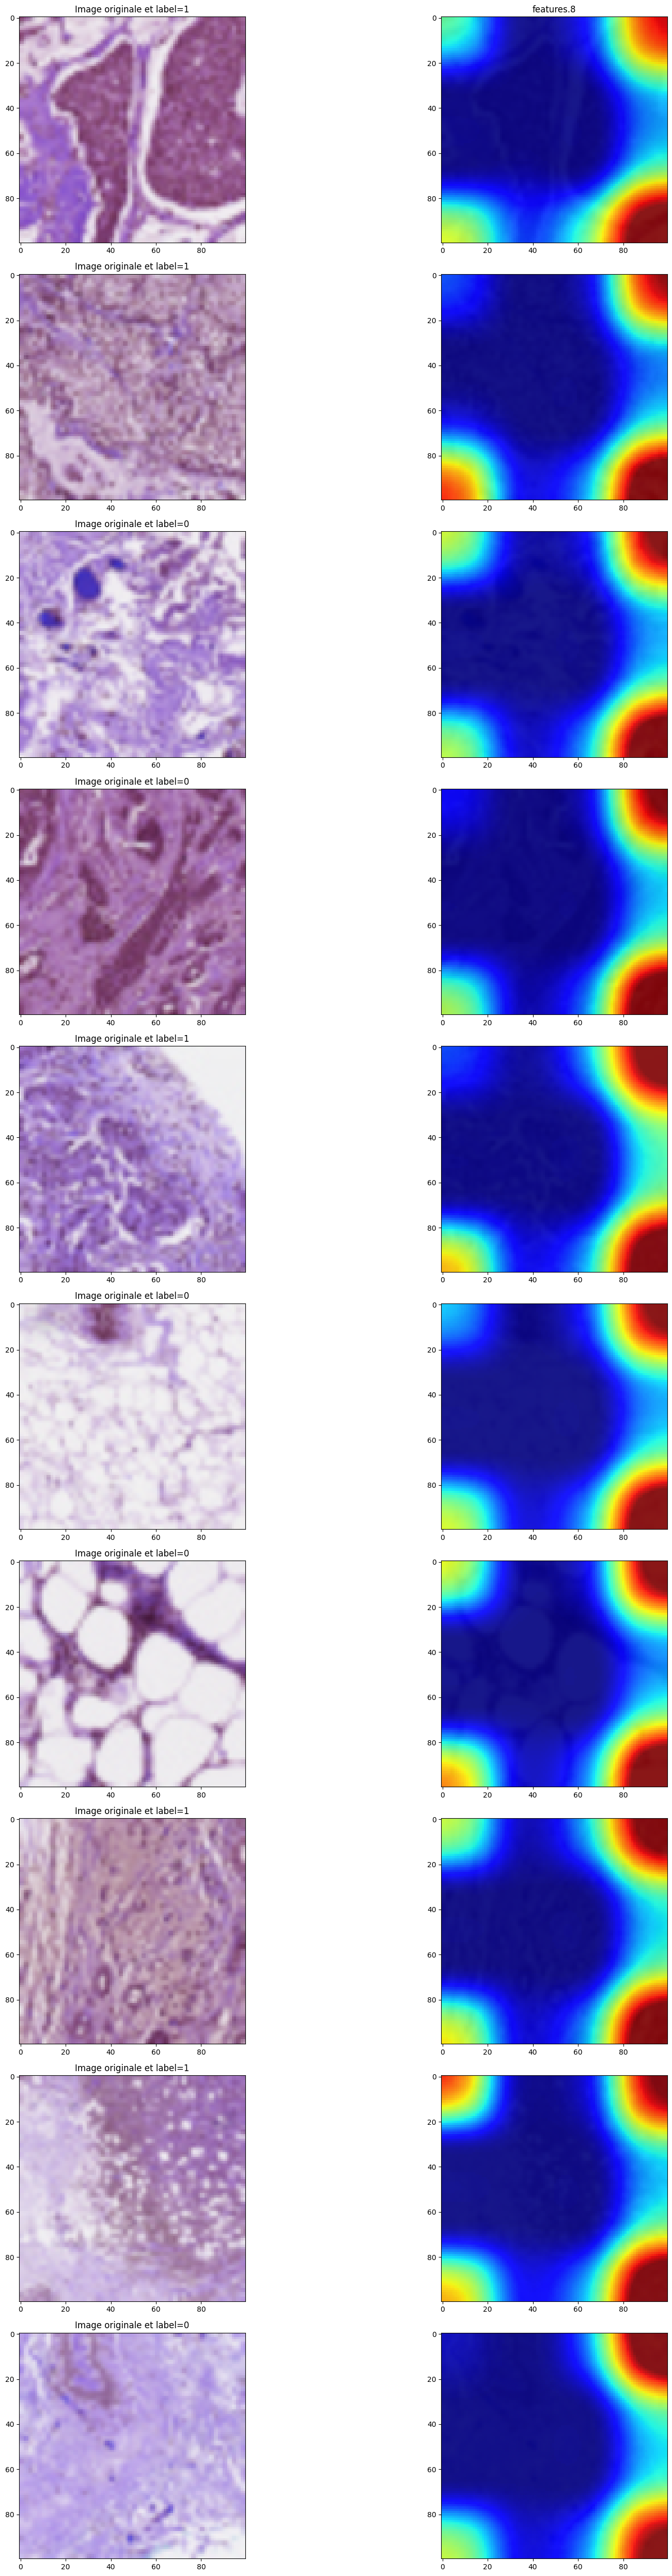

In [178]:
#grad cam pour efficient net
couche_cible3 = ["features.8"]
gradcam_affiche(model_efficientb0, test_dataset_pré,device,couche_cible3)

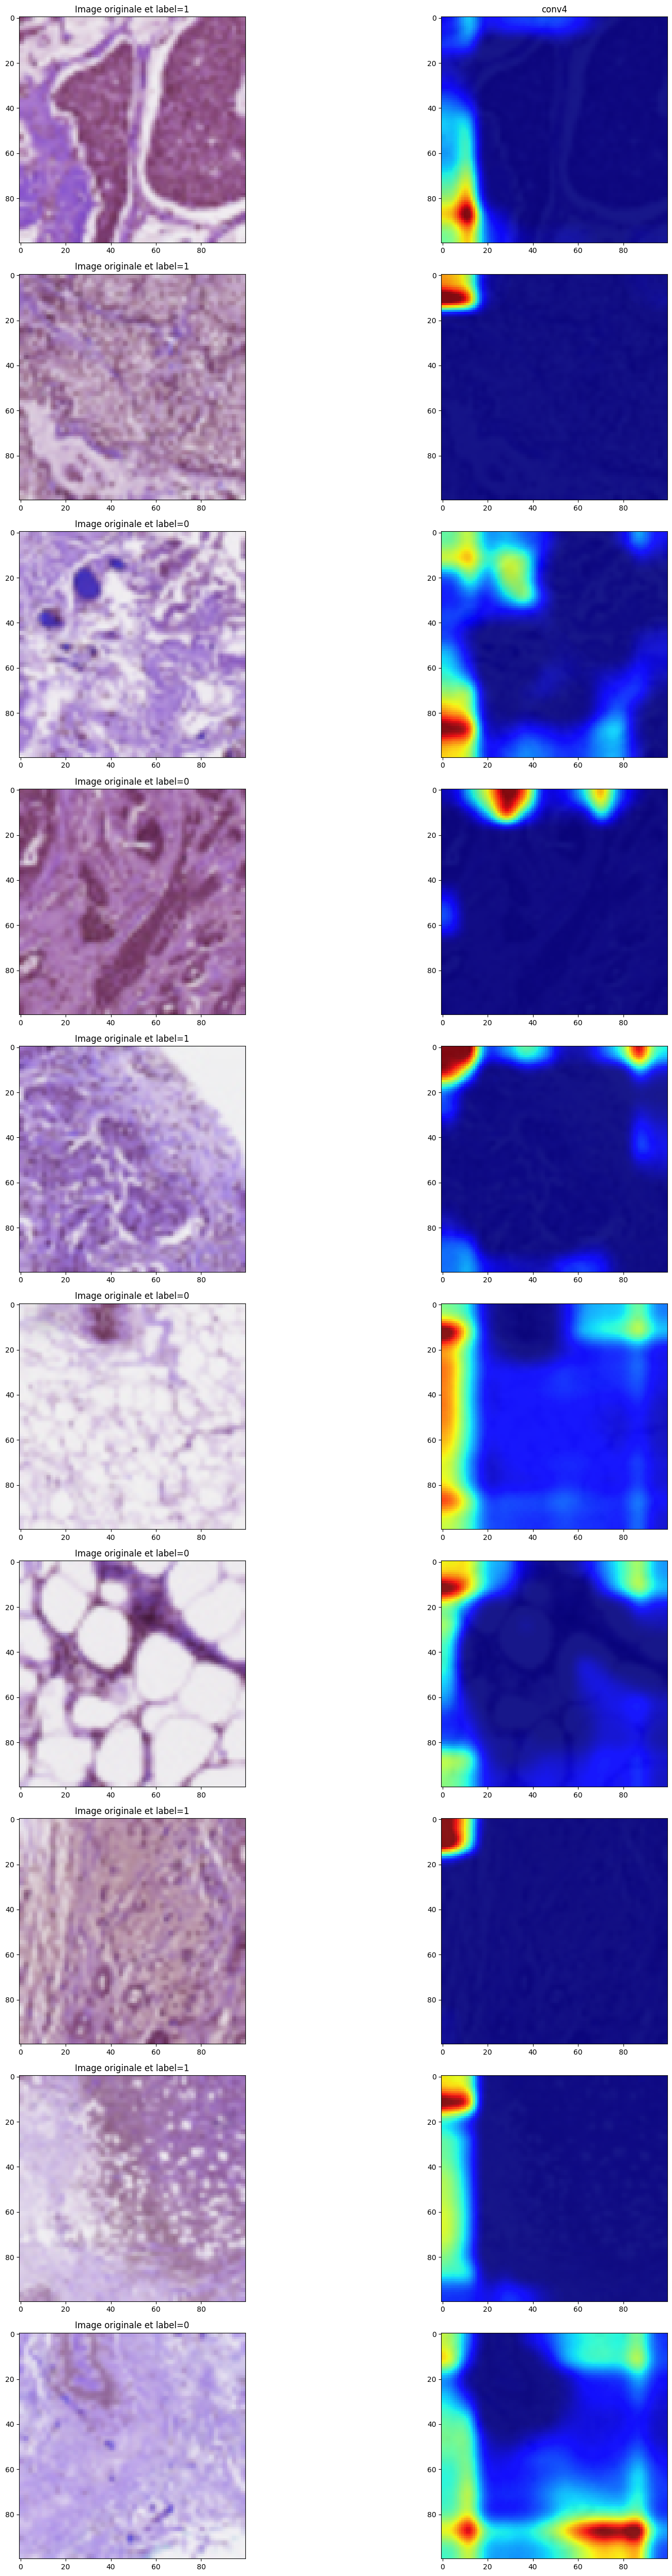

In [179]:
#pour notre modèle
couche_cible4 = ["conv4"]
gradcam_affiche(model2, test_dataset,device,couche_cible4)

## Conclusion
- <font color="blue"> Parlons d'abord des difficultés que nous avons rencontrées dans ce projet: la réproductinilité a été un défis majeur. En effet malgré l'utilisation des seeds, on a remarqué qu'à chaque entrainement le modèle ressorti était différent et donc des mini conclusions différentes, aussi les images étant choisies aléatoirement on n'a pas un bon contrôle sur la qualité des images, ce qui rend l'entrainement difficile, en partie cela peut aussi se comprendre car dans la vie réelle on est confronté à ce genre de problèmes; N'étant pas des experts en imageries médicales,  on se reserve de faire une argumentation profonde des GRAD-CAM.
- Pour le choix du modèle il y avait plusieurs paramètres à prendre en compte notamment la performance,stabilité, l'interprétabilité des GRAD-CAM, capacité de généralisation,etc; si un modèle devrait être choisi EfficientNetB0 appariait comme le meilleur compromis(meilleur contrôle sur la prédiction des deux classes, bonnes métriques(recall,f1-score,AUC). Cependant si notre objectif est de dimunier au maximum des FN, le modèle Resnet18 peut être choisi, car il  avait très souvent le plus faible nombre FN(avec le plus grand grand nombre de FP aussi).
- Pour les perspectives on pourrait envisager un meilleur équilibrage des données, une bonne qualité des images, explorer d'autres architectures modernes comme les Vision Transformers,etc</font>


## Work by yourself

The goal of this project is for you to develop autonomously a whole deep learning pipeline to classify the patch images into IDC negative (0) and IDC positive (1). To complete the assignment, you are required to address the following points:

***Set-up your pipeline:***
- Explore the data with summaries and visualization to understand whether classes are balanced, what the images look like, etc.
- Split the data into training, test and validation sets.
- Create PyTorch data sets containing images and labels.
- Be careful with the format of your image objects, sometimes we need to store them as arrays, sometimes as PIL images.
- Train a first model to predict IDC classification and evaluate it on the validation data.

***Improve the performance of your model:***
- Experiment with different network architectures and with pre-trained models.
- Data augmentation works well to improve the performance of vision classifiers. Check the [documentation](https://docs.pytorch.org/vision/main/transforms.html) to learn how to include data augmentation in your PyTorch `transform`.
- Tune the hyperparameters of the different models and compare their performance using different evaluation metrics.

***Interpret your results:***
- Implement an interpretation analysis using one or several tools of your choice. For instance, you can check the documentation of the python implementations of [Grad-CAM](https://pypi.org/project/pytorch-gradcam/), [LIME](https://pypi.org/project/lime/) and [SHAP](https://pypi.org/project/shap/).
- Provide visual representations of the interpretation analysis, for instance on a few chosen images, and comment the results.
- Provide a general conclusion to your project which summarizes your results and findings, as well as possible ideas of improvement.